# 0.1 - Import Requirements

## 0.2 - Import Libraries

In [ ]:
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

## 0.3 - Import Dataset

In [2]:
if not os.path.exists('..\data\product_sales.csv'):
    print("File not found, downloading the dataset...")
    
    # Create directory if it doesn't exist
    os.makedirs('..\data', exist_ok=True)
    
    api = KaggleApi()
    api.authenticate()
    
    # Download dataset
    api.dataset_download_files('kpradyumna/product-sales-forecasting', path='../data', unzip=True)
    os.rename('../data/Task2Data (1).csv', '../data/product_sales.csv')
    
    print('Dataset downloaded and renamed successfully!')
else:
    print('File already exists, no need to download again.')

File already exists, no need to download again.


# 1.0 - Load Dataset

In [3]:
df = pd.read_csv('..\data\product_sales.csv')

In [4]:
df.head(10)

Date    Sale  Temperature
0  01-04-2018  74.536        36.60
1  02-04-2018  69.839        37.26
2  03-04-2018  71.016        36.94
3  04-04-2018  71.544        36.49
4  05-04-2018  70.367        36.91
5  06-04-2018  71.753        37.30
6  07-04-2018  67.276        37.21
7  08-04-2018  65.560        37.27
8  09-04-2018  69.509        36.97
9  10-04-2018  62.040        38.14

## 2.0 - Data Cleaning and Preparation

## 2.1 - Filling Null Values

In [5]:
# Check for missing values
print(df.isnull().sum())

Date            0
Sale           44
Temperature     2
dtype: int64


In [ ]:
# Fill null values
# 1. Fill 'Sale' column with median (less sensitive to outliers)
df['Sale'].fillna(df['Sale'].median(), inplace=True)

# 2. Fill 'Temperature' column with interpolation (maintains temporal pattern)
df['Temperature'].fillna(df['Temperature'].mean(), inplace=True)

In [7]:
# Check for missing values after treatment
print("Null values after treatment:")
print(df.isnull().sum())

Null values after treatment:
Date           0
Sale           0
Temperature    0
dtype: int64


## 2.2 - Converting 'Date' Column

This transforms the date from text to calendar format. This way, Python understands it's a timeline.

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

# Sort data from oldest to newest
df = df.sort_values('Date')

# Set date as table index
df.set_index('Date', inplace=True)

# 3.0 - EDA (Exploratory Data Analysis)

## 3.1 - Basic Dataset Information

In [9]:
print('=== BASIC DATASET INFORMATION ===')
print(f"Data shape: {df.shape}")
print(f'Data period: {df.index.min()} to {df.index.max()}')

# Check if we have a frequency index
if isinstance(df.index, pd.DatetimeIndex):
    print(f'Data frequency: {df.index.freq}')
    # If no frequency is automatically detected, let's infer it
    if df.index.freq is None:
        freq = pd.infer_freq(df.index)
        print(f'Inferred frequency: {freq}')
else:
    print('Index is not temporal - check date conversion')

print('\n=== DATA TYPES ===')
print(df.dtypes)
print('\n=== FIRST ROWS ===')
print(df.head(5))

=== BASIC DATASET INFORMATION ===
Data shape: (884, 2)
Data period: 2018-01-04 00:00:00 to 2020-12-08 00:00:00
Data frequency: None
Inferred frequency: None

=== DATA TYPES ===
Sale           float64
Temperature    float64
dtype: object

=== FIRST ROWS ===
               Sale  Temperature
Date                            
2018-01-04   74.536        36.60
2018-01-05   74.426        37.24
2018-01-06   60.335        39.43
2018-01-07  119.383        36.99
2018-01-08  107.217        37.33


## 3.2 - Descriptive Statistical Analysis

In [10]:
# Descriptive statistics
print(f'=== DESCRIPTIVE STATISTICS ===')
print(df.describe())

# Correlation analysis
print('\n=== CORRELATION MATRIX ===')
correlation_matrix = df.corr()
print(correlation_matrix)

=== DESCRIPTIVE STATISTICS ===
             Sale  Temperature
count  884.000000   884.000000
mean   106.558070    34.683583
std     35.504949     3.232470
min     51.788000    27.150000
25%     88.096250    32.055000
50%    101.018500    35.015000
75%    116.638500    37.212500
max    294.294000    42.180000

=== CORRELATION MATRIX ===
                 Sale  Temperature
Sale         1.000000    -0.284829
Temperature -0.284829     1.000000

             Sale  Temperature
count  884.000000   884.000000
mean   106.558070    34.683583
std     35.504949     3.232470
min     51.788000    27.150000
25%     88.096250    32.055000
50%    101.018500    35.015000
75%    116.638500    37.212500
max    294.294000    42.180000

=== CORRELATION MATRIX ===
                 Sale  Temperature
Sale         1.000000    -0.284829
Temperature -0.284829     1.000000


## 3.3 - Correlation Matrix Visualization

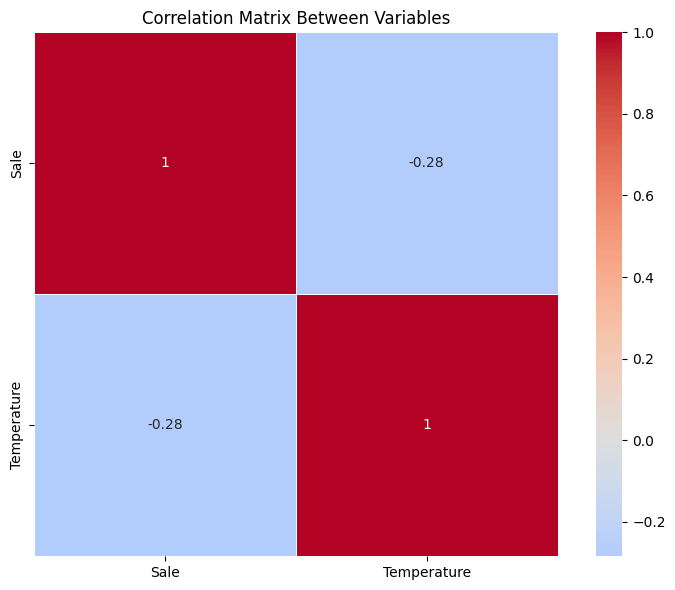

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix Between Variables')
plt.tight_layout()
plt.show()

## 3.4 - Time Series Visualizations

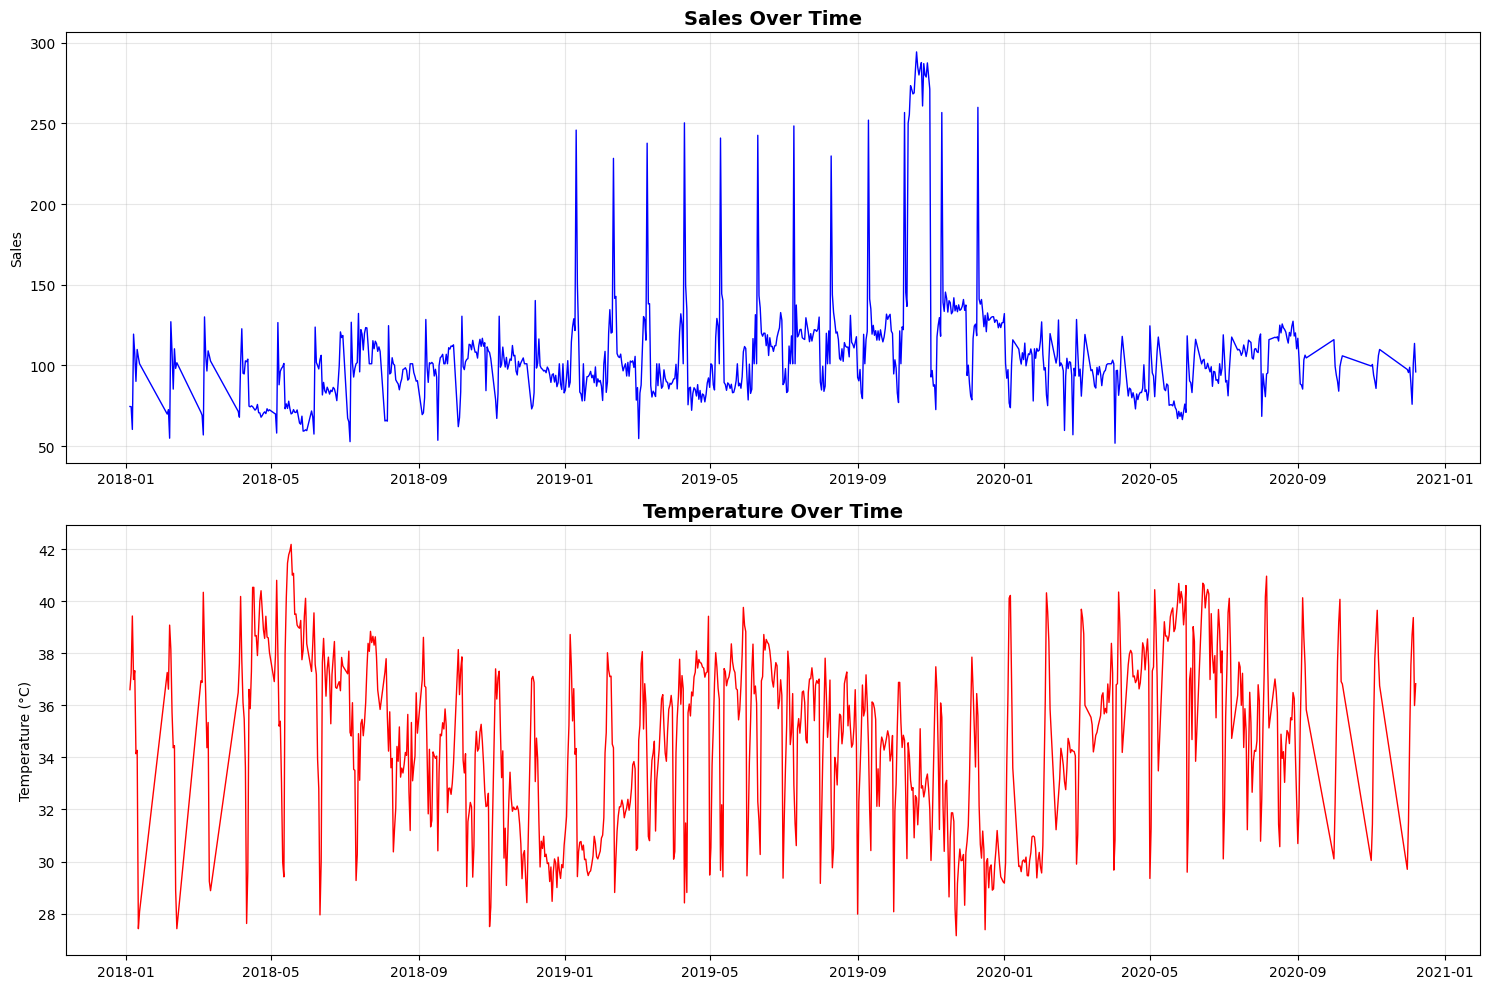

In [12]:
# Time Series Visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Sales over time plot
axes[0].plot(df.index, df['Sale'], linewidth=1, color='blue')
axes[0].set_title('Sales Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sales')
axes[0].grid(True, alpha=0.3)

# Temperature over time plot
axes[1].plot(df.index, df['Temperature'], color='red', linewidth=1)
axes[1].set_title('Temperature Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Temperature (¬∞C)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3.5 - Distribution Analysis

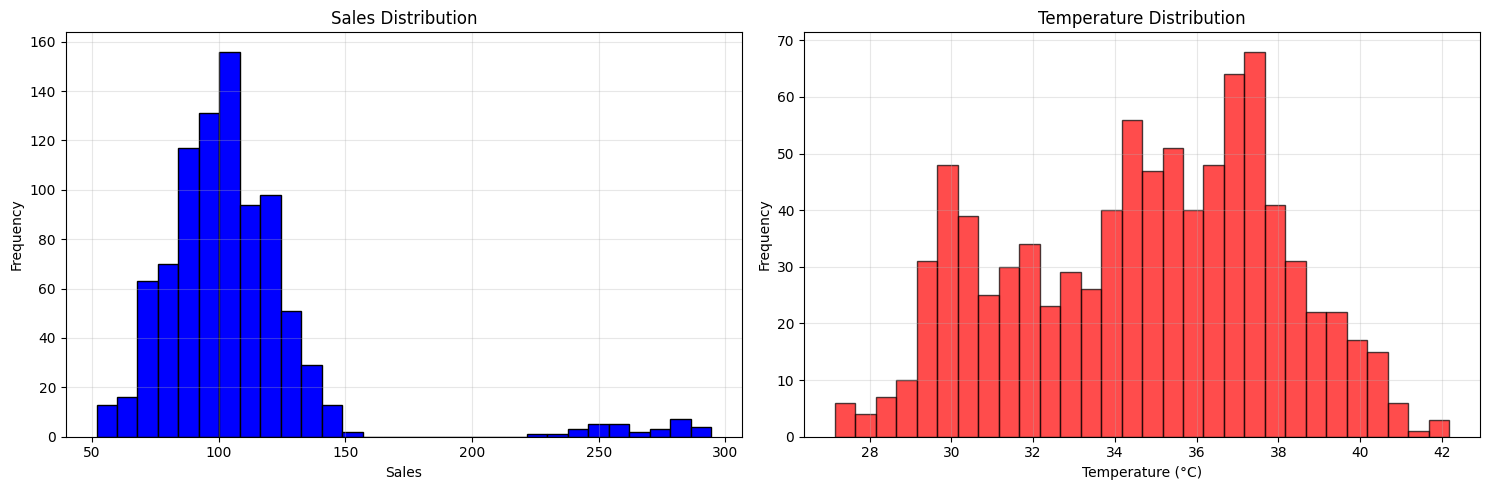

In [13]:
# Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sales histogram
axes[0].hist(df['Sale'], bins=30, color='blue', edgecolor='black')
axes[0].set_title('Sales Distribution')
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Temperature histogram
axes[1].hist(df['Temperature'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1].set_title('Temperature Distribution')
axes[1].set_xlabel('Temperature (¬∞C)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3.6 - Monthly Seasonality Analysis

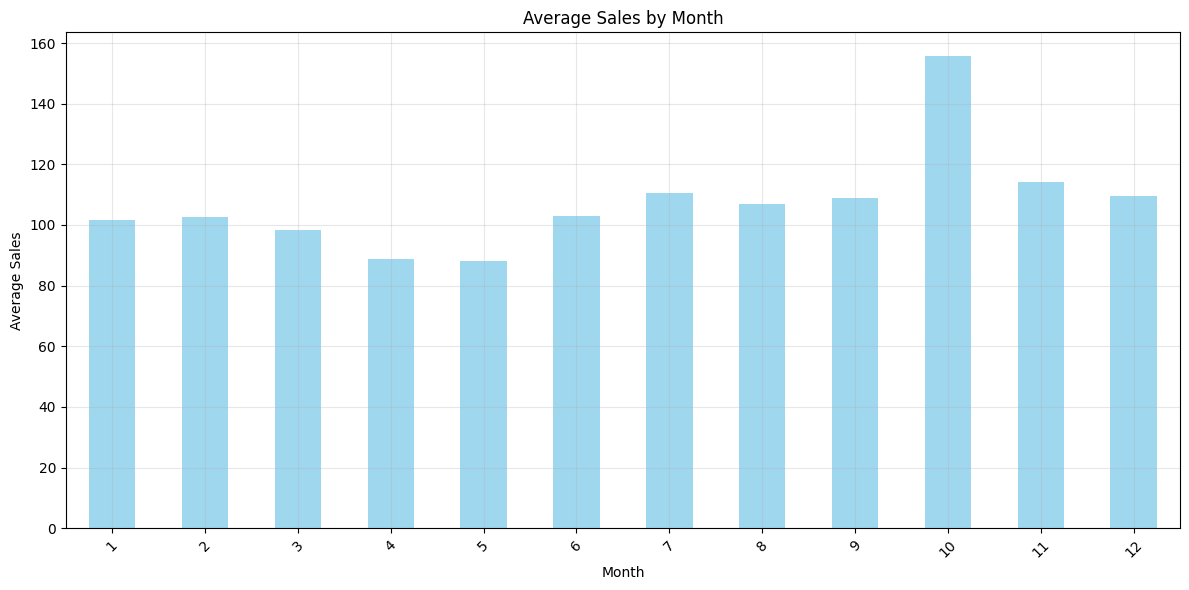

In [14]:
# Monthly Seasonality
df['Month'] = df.index.month
df['Year'] = df.index.year

# Sales by month
monthly_sales = df.groupby('Month')['Sale'].mean()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3.7 - Annual Trend Analysis

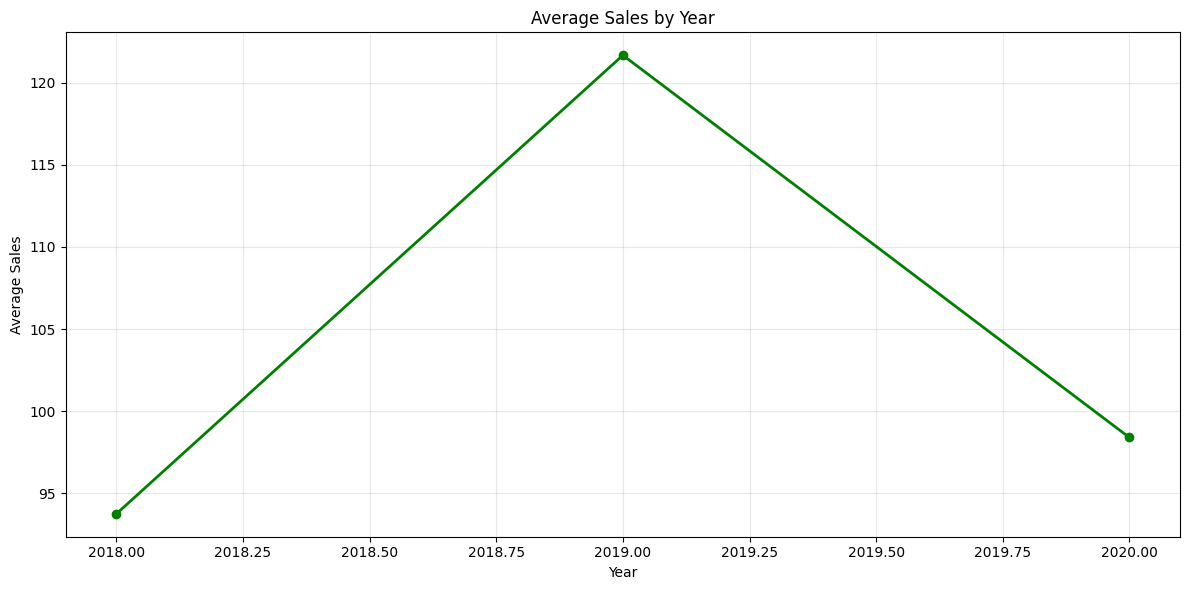

In [15]:
# Annual Trend
yearly_sales = df.groupby('Year')['Sale'].mean()
plt.figure(figsize=(12, 6))
yearly_sales.plot(kind='line', marker='o', color='green', linewidth=2)
plt.title('Average Sales by Year')
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3.8 - Outlier Detection

=== OUTLIER DETECTION - SALE ===
Q1: 88.10
Q3: 116.64
IQR: 28.54
Lower limit: 45.28
Upper limit: 159.45
Number of outliers: 31
Percentage of outliers: 3.51%
=== OUTLIER DETECTION - TEMPERATURE ===
Q1: 32.05
Q3: 37.21
IQR: 5.16
Lower limit: 24.32
Upper limit: 44.95
Number of outliers: 0
Percentage of outliers: 0.00%


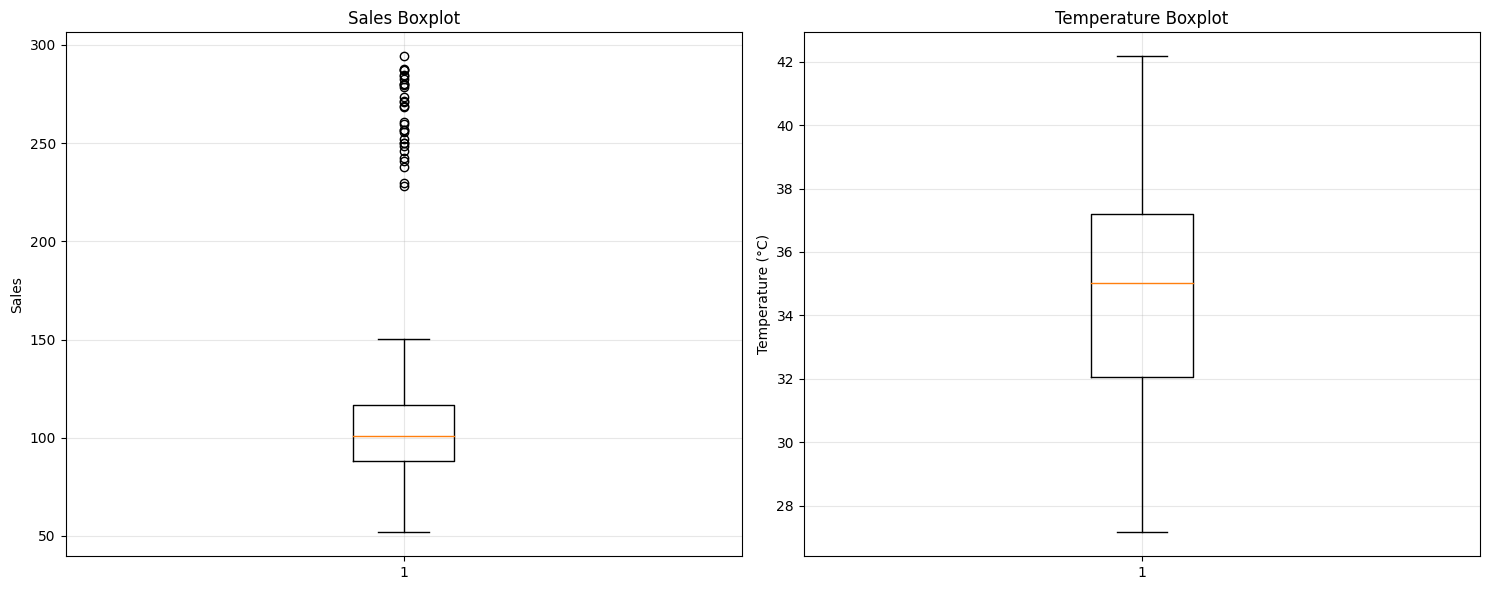


First 5 sales outliers:
               Sale  Temperature
Date                            
2019-01-10  245.828        34.34
2019-02-10  228.316        34.37
2019-03-10  237.710        33.65
2019-04-10  250.316        28.41
2019-05-10  240.900        29.66


In [16]:
# Outlier Detection using IQR method
def detect_outliers(df, column):
    """
    Detects outliers using the IQR (Interquartile Range) method
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier limits
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)]
    
    print(f"=== OUTLIER DETECTION - {column.upper()} ===")
    print(f"Q1: {Q1:.2f}")
    print(f"Q3: {Q3:.2f}")
    print(f"IQR: {IQR:.2f}")
    print(f"Lower limit: {lower_limit:.2f}")
    print(f"Upper limit: {upper_limit:.2f}")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {len(outliers)/len(df)*100:.2f}%")
    
    return outliers, lower_limit, upper_limit

# Detect sales outliers
sales_outliers, lower_sales, upper_sales = detect_outliers(df, 'Sale')

# Detect temperature outliers
temp_outliers, lower_temp, upper_temp = detect_outliers(df, 'Temperature')

# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sales boxplot
axes[0].boxplot(df['Sale'])
axes[0].set_title('Sales Boxplot')
axes[0].set_ylabel('Sales')
axes[0].grid(True, alpha=0.3)

# Temperature boxplot
axes[1].boxplot(df['Temperature'])
axes[1].set_title('Temperature Boxplot')
axes[1].set_ylabel('Temperature (¬∞C)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show some observations with outliers
if len(sales_outliers) > 0:
    print(f"\nFirst 5 sales outliers:")
    print(sales_outliers[['Sale', 'Temperature']].head())
    
if len(temp_outliers) > 0:
    print(f"\nFirst 5 temperature outliers:")
    print(temp_outliers[['Sale', 'Temperature']].head())

### 3.8.1 - Outlier Boxplots Interpretation

In [ ]:
# Detailed Outlier Boxplots Interpretation
def interpret_boxplots(df, sales_outliers, temp_outliers):
    """
    Interprets the results of boxplots and detected outliers
    """
    print("="*60)
    print("üìä OUTLIER BOXPLOTS INTERPRETATION")
    print("="*60)
    
    # An√°lise do Boxplot de Vendas
    print("\nüîç AN√ÅLISE DO BOXPLOT DE VENDAS:")
    print("-" * 40)
    
    # Estat√≠sticas b√°sicas
    q1_vendas = df['Sale'].quantile(0.25)
    q2_vendas = df['Sale'].median()
    q3_vendas = df['Sale'].quantile(0.75)
    iqr_vendas = q3_vendas - q1_vendas
    
    print(f"üìà Distribui√ß√£o das Vendas:")
    print(f"   ‚Ä¢ Q1 (25%): {q1_vendas:.1f} - 25% das vendas est√£o abaixo deste valor")
    print(f"   ‚Ä¢ Mediana (50%): {q2_vendas:.1f} - valor central das vendas")
    print(f"   ‚Ä¢ Q3 (75%): {q3_vendas:.1f} - 75% das vendas est√£o abaixo deste valor")
    print(f"   ‚Ä¢ IQR: {iqr_vendas:.1f} - amplitude entre Q1 e Q3")
    
    # Interpreta√ß√£o dos outliers de vendas
    if len(sales_outliers) > 0:
        outlier_max = sales_outliers['Sale'].max()
        outlier_min = sales_outliers['Sale'].min()
        print(f"\n‚ö†Ô∏è  OUTLIERS DETECTADOS EM VENDAS:")
        print(f"   ‚Ä¢ {len(sales_outliers)} outliers ({len(sales_outliers)/len(df)*100:.1f}% of data)")
        print(f"   ‚Ä¢ Maior outlier: {outlier_max:.1f} vendas")
        print(f"   ‚Ä¢ Menor outlier: {outlier_min:.1f} vendas")
        print(f"   ‚Ä¢ Os pontos circulares no gr√°fico representam estes valores extremos")
        
        # Contexto dos outliers
        if outlier_max > q3_vendas + 2*iqr_vendas:
            print(f"   ‚Ä¢ INSIGHT: Vendas excepcionalmente altas (>280) podem indicar:")
            print(f"     - Promo√ß√µes especiais")
            print(f"     - Eventos sazonais (feriados)")
            print(f"     - Condi√ß√µes clim√°ticas favor√°veis")
    else:
        print(f"\n‚úÖ Nenhum outlier detectado em vendas")
    
    # An√°lise do Boxplot de Temperatura
    print("\nüå°Ô∏è AN√ÅLISE DO BOXPLOT DE TEMPERATURA:")
    print("-" * 40)
    
    # Estat√≠sticas b√°sicas
    q1_temp = df['Temperature'].quantile(0.25)
    q2_temp = df['Temperature'].median()
    q3_temp = df['Temperature'].quantile(0.75)
    iqr_temp = q3_temp - q1_temp
    
    print(f"üå°Ô∏è Distribui√ß√£o da Temperatura:")
    print(f"   ‚Ä¢ Q1 (25%): {q1_temp:.1f}¬∞C - 25% dos dias t√™m temperatura abaixo")
    print(f"   ‚Ä¢ Mediana (50%): {q2_temp:.1f}¬∞C - temperatura t√≠pica")
    print(f"   ‚Ä¢ Q3 (75%): {q3_temp:.1f}¬∞C - 75% dos dias t√™m temperatura abaixo")
    print(f"   ‚Ä¢ IQR: {iqr_temp:.1f}¬∞C - amplitude t√©rmica central")
    
    # Interpreta√ß√£o dos outliers de temperatura
    if len(temp_outliers) > 0:
        temp_max = temp_outliers['Temperature'].max()
        temp_min = temp_outliers['Temperature'].min()
        print(f"\n‚ö†Ô∏è  OUTLIERS DETECTADOS EM TEMPERATURA:")
        print(f"   ‚Ä¢ {len(temp_outliers)} outliers ({len(temp_outliers)/len(df)*100:.1f}% of data)")
        print(f"   ‚Ä¢ Temperatura m√°xima outlier: {temp_max:.1f}¬∞C")
        print(f"   ‚Ä¢ Temperatura m√≠nima outlier: {temp_min:.1f}¬∞C")
        
        # Contexto dos outliers
        if temp_max > 40:
            print(f"   ‚Ä¢ INSIGHT: Temperaturas muito altas (>40¬∞C) podem indicar:")
            print(f"     - Ondas de calor")
            print(f"     - Ver√£o extremo")
            print(f"     - Poss√≠vel impacto nas vendas")
        if temp_min < 25:
            print(f"   ‚Ä¢ INSIGHT: Temperaturas baixas (<25¬∞C) podem indicar:")
            print(f"     - Per√≠odo de inverno")
            print(f"     - Frentes frias")
            print(f"     - Mudan√ßa no padr√£o de consumo")
    else:
        print(f"\n‚úÖ Nenhum outlier detectado em temperatura")
    
    # An√°lise conjunta
    print(f"\nüîó AN√ÅLISE CONJUNTA VENDAS vs TEMPERATURA:")
    print("-" * 50)
    
    # Correla√ß√£o
    correlacao = df['Sale'].corr(df['Temperature'])
    print(f"üìä Correla√ß√£o Vendas-Temperatura: {correlacao:.3f}")
    
    if correlacao > 0.3:
        print(f"   ‚Ä¢ FORTE correla√ß√£o positiva: temperaturas altas = mais vendas")
    elif correlacao > 0.1:
        print(f"   ‚Ä¢ MODERADA correla√ß√£o positiva: alguma rela√ß√£o temperatura-vendas")
    elif correlacao > -0.1:
        print(f"   ‚Ä¢ FRACA correla√ß√£o: pouca rela√ß√£o entre temperatura e vendas")
    else:
        print(f"   ‚Ä¢ Correla√ß√£o NEGATIVA: temperaturas altas = menos vendas")
    
    # Recomenda√ß√µes
    print(f"\nüí° RECOMENDA√á√ïES PARA MODELAGEM:")
    print("-" * 40)
    
    if len(sales_outliers) > len(df) * 0.05:  # More than 5% outliers
        print(f"   ‚Ä¢ ‚ö†Ô∏è  Many sales outliers ({len(sales_outliers)/len(df)*100:.1f}%)")
        print(f"   ‚Ä¢ Considere investigar e tratar outliers antes da modelagem")
        print(f"   ‚Ä¢ Op√ß√µes: winsoriza√ß√£o, transforma√ß√£o log, modelos robustos")
    else:
        print(f"   ‚Ä¢ ‚úÖ Quantidade aceit√°vel de outliers em vendas")
        print(f"   ‚Ä¢ Pode manter dados originais na modelagem")
    
    if len(temp_outliers) > 0:
        print(f"   ‚Ä¢ üå°Ô∏è Temperature outliers may be seasonal (normal)")
        print(f"   ‚Ä¢ Consider seasonality features in modeling")
    
    print(f"   ‚Ä¢ üìà Use a correla√ß√£o temperatura-vendas como feature importante")
    
    return {
        'sales_outliers': len(sales_outliers),
        'temp_outliers': len(temp_outliers),
        'correlacao': correlacao,
        'interpretacao': 'completa'
    }

# Executar interpreta√ß√£o
interpretacao = interpret_boxplots(df, sales_outliers, temp_outliers)

üìä OUTLIER BOXPLOTS INTERPRETATION

üîç AN√ÅLISE DO BOXPLOT DE VENDAS:
----------------------------------------
üìà Distribui√ß√£o das Vendas:
   ‚Ä¢ Q1 (25%): 88.1 - 25% das vendas est√£o abaixo deste valor
   ‚Ä¢ Mediana (50%): 101.0 - valor central das vendas
   ‚Ä¢ Q3 (75%): 116.6 - 75% das vendas est√£o abaixo deste valor
   ‚Ä¢ IQR: 28.5 - amplitude entre Q1 e Q3

‚ö†Ô∏è  OUTLIERS DETECTADOS EM VENDAS:
   ‚Ä¢ 31 outliers (3.5% of data)
   ‚Ä¢ Maior outlier: 294.3 vendas
   ‚Ä¢ Menor outlier: 228.3 vendas
   ‚Ä¢ Os pontos circulares no gr√°fico representam estes valores extremos
   ‚Ä¢ INSIGHT: Vendas excepcionalmente altas (>280) podem indicar:
     - Promo√ß√µes especiais
     - Eventos sazonais (feriados)
     - Condi√ß√µes clim√°ticas favor√°veis

üå°Ô∏è AN√ÅLISE DO BOXPLOT DE TEMPERATURA:
----------------------------------------
üå°Ô∏è Distribui√ß√£o da Temperatura:
   ‚Ä¢ Q1 (25%): 32.1¬∞C - 25% dos dias t√™m temperatura abaixo
   ‚Ä¢ Mediana (50%): 35.0¬∞C - temperatu

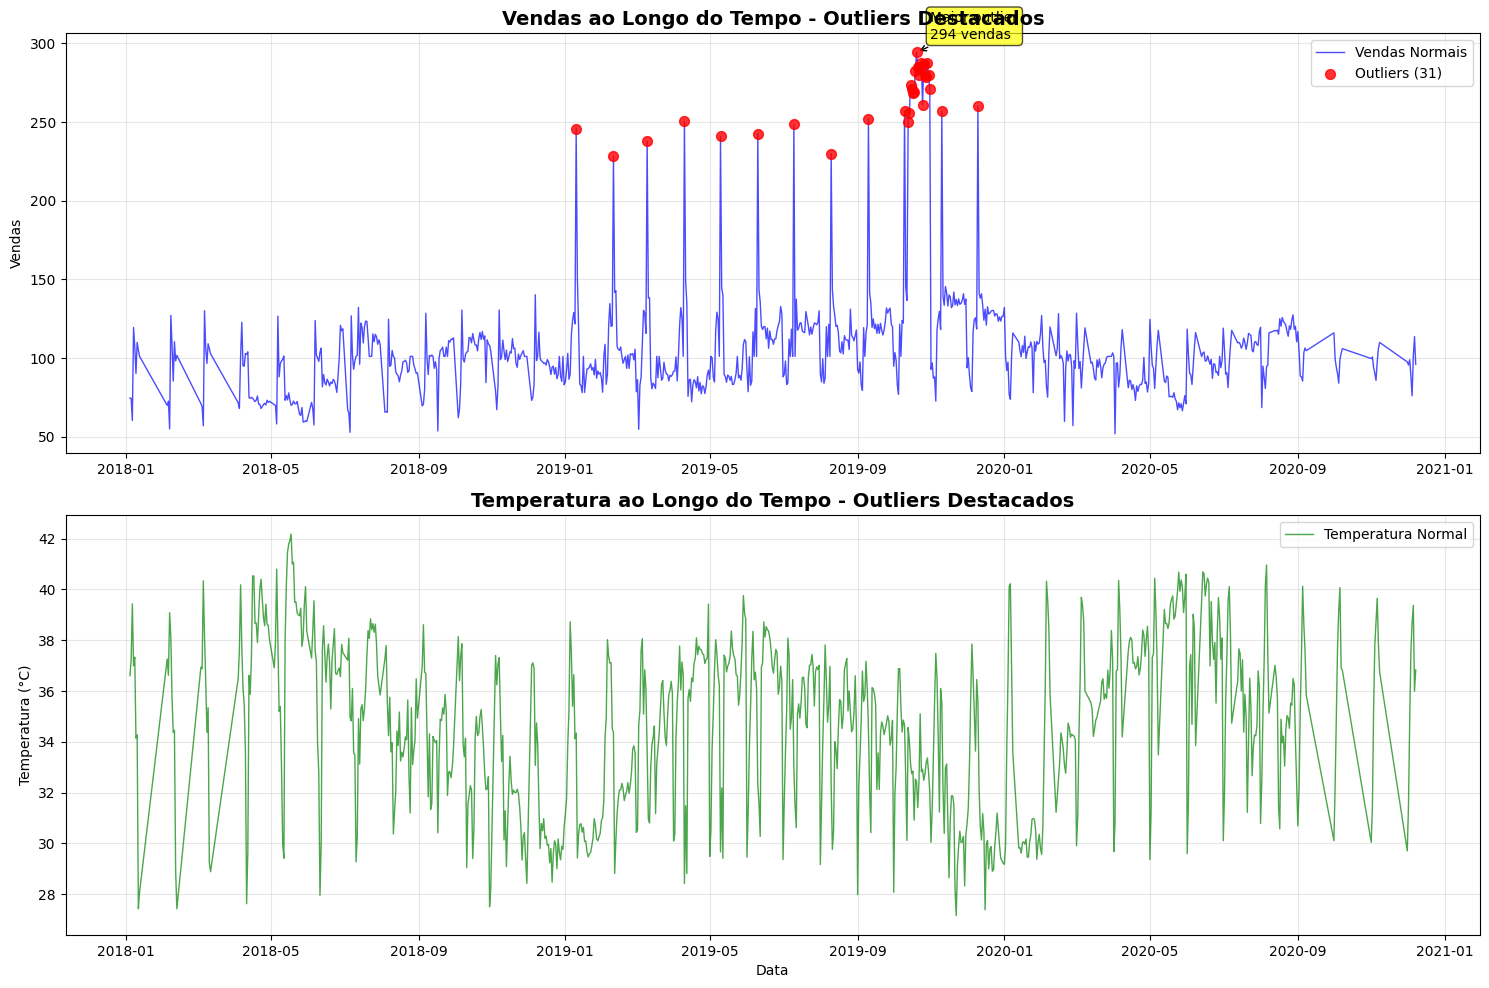


üìÖ QUANDO OS OUTLIERS DE VENDAS OCORREM:
---------------------------------------------
Outliers por m√™s:
   ‚Ä¢ Jan: 1 outliers
   ‚Ä¢ Fev: 1 outliers
   ‚Ä¢ Mar: 1 outliers
   ‚Ä¢ Abr: 1 outliers
   ‚Ä¢ Mai: 1 outliers
   ‚Ä¢ Jun: 1 outliers
   ‚Ä¢ Jul: 1 outliers
   ‚Ä¢ Ago: 1 outliers
   ‚Ä¢ Set: 1 outliers
   ‚Ä¢ Out: 20 outliers
   ‚Ä¢ Nov: 1 outliers
   ‚Ä¢ Dez: 1 outliers

üî• M√™s com MAIS outliers: Out (20 outliers)
   Poss√≠vel explica√ß√£o: alta temporada, feriados, ou eventos especiais


In [18]:
# Outliers ao Longo do Tempo
def visualize_temporal_outliers(df, sales_outliers, temp_outliers):
    """
    Mostra quando os outliers ocorreram ao longo do tempo
    """
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Gr√°fico 1: Vendas com outliers destacados
    axes[0].plot(df.index, df['Sale'], color='blue', alpha=0.7, linewidth=1, label='Vendas Normais')
    
    if len(sales_outliers) > 0:
        axes[0].scatter(sales_outliers.index, sales_outliers['Sale'], 
                       color='red', s=50, alpha=0.8, label=f'Outliers ({len(sales_outliers)})', zorder=5)
        
        # Destacar os outliers mais extremos
        outlier_extremo = sales_outliers.loc[sales_outliers['Sale'].idxmax()]
        axes[0].annotate(f'Maior outlier\n{outlier_extremo["Sale"]:.0f} vendas', 
                        xy=(outlier_extremo.name, outlier_extremo['Sale']),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    axes[0].set_title('Vendas ao Longo do Tempo - Outliers Destacados', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Vendas')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Gr√°fico 2: Temperatura com outliers destacados
    axes[1].plot(df.index, df['Temperature'], color='green', alpha=0.7, linewidth=1, label='Temperatura Normal')
    
    if len(temp_outliers) > 0:
        axes[1].scatter(temp_outliers.index, temp_outliers['Temperature'], 
                       color='red', s=50, alpha=0.8, label=f'Outliers ({len(temp_outliers)})', zorder=5)
        
        # Destacar temperaturas extremas
        if temp_outliers['Temperature'].max() > df['Temperature'].quantile(0.95):
            temp_extrema = temp_outliers.loc[temp_outliers['Temperature'].idxmax()]
            axes[1].annotate(f'Temp. m√°xima\n{temp_extrema["Temperature"]:.1f}¬∞C', 
                            xy=(temp_extrema.name, temp_extrema['Temperature']),
                            xytext=(10, 10), textcoords='offset points',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
                            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    axes[1].set_title('Temperatura ao Longo do Tempo - Outliers Destacados', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Temperatura (¬∞C)')
    axes[1].set_xlabel('Data')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # An√°lise sazonal dos outliers
    if len(sales_outliers) > 0:
        print(f"\nüìÖ QUANDO OS OUTLIERS DE VENDAS OCORREM:")
        print("-" * 45)
        
        # Agrupar outliers por m√™s
        outliers_por_mes = sales_outliers.groupby(sales_outliers.index.month)['Sale'].count()
        
        meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
                'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
        
        print("Outliers por m√™s:")
        for mes_num, count in outliers_por_mes.items():
            print(f"   ‚Ä¢ {meses[mes_num-1]}: {count} outliers")
        
        # M√™s com mais outliers
        mes_mais_outliers = outliers_por_mes.idxmax()
        print(f"\nüî• M√™s com MAIS outliers: {meses[mes_mais_outliers-1]} ({outliers_por_mes.max()} outliers)")
        print(f"   Poss√≠vel explica√ß√£o: alta temporada, feriados, ou eventos especiais")

# Executar visualiza√ß√£o temporal
print("="*60)
visualize_temporal_outliers(df, sales_outliers, temp_outliers)

# 4.0 - Stationarity Testing

In [19]:
# Augmented Dickey-Fuller Test
def teste_estacionariedade(serie, nome_serie):
    '''
    Teste se a s√©rie √© estacion√°ria usando o teste ADF.
    '''
    print(f'\n=== TESTE DE ESTACIONARIEDADE - {nome_serie} ===')
    
    # Teste ADF
    resultado = adfuller(serie.dropna())
    
    print(f'Estat√≠stica ADF: {resultado[0]:.6f}')
    print(f'p-valor: {resultado[1]:.6f}')
    print('Valores cr√≠ticos:')
    for key, value in resultado[4].items():
        print(f'\t{key}: {value:.3f}')
        
    # Interpreta√ß√£o
    if resultado[1] <= 0.05:
        print('A s√©rie √© estacion√°ria (rejeitamos a hip√≥tese nula).')
    else:
        print('A s√©rie n√£o √© estacion√°ria (n√£o rejeitamos a hip√≥tese nula).')
    
    return resultado[1] <= 0.05  # Retorna True se estacion√°ria

# Testar estacionariedade
estacionaria_vendas = teste_estacionariedade(df['Sale'], 'Vendas')
print('\n')
estacionaria_temp = teste_estacionariedade(df['Temperature'], 'Temperatura')


=== TESTE DE ESTACIONARIEDADE - Vendas ===
Estat√≠stica ADF: -4.680620
p-valor: 0.000091
Valores cr√≠ticos:
	1%: -3.438
	5%: -2.865
	10%: -2.569
A s√©rie √© estacion√°ria (rejeitamos a hip√≥tese nula).



=== TESTE DE ESTACIONARIEDADE - Temperatura ===
Estat√≠stica ADF: -4.379001
p-valor: 0.000323
Valores cr√≠ticos:
	1%: -3.438
	5%: -2.865
	10%: -2.569
A s√©rie √© estacion√°ria (rejeitamos a hip√≥tese nula).
Estat√≠stica ADF: -4.379001
p-valor: 0.000323
Valores cr√≠ticos:
	1%: -3.438
	5%: -2.865
	10%: -2.569
A s√©rie √© estacion√°ria (rejeitamos a hip√≥tese nula).


## 4.1 - Time Series Decomposition

=== DECOMPOSI√á√ÉO DA S√âRIE DE VENDAS ===


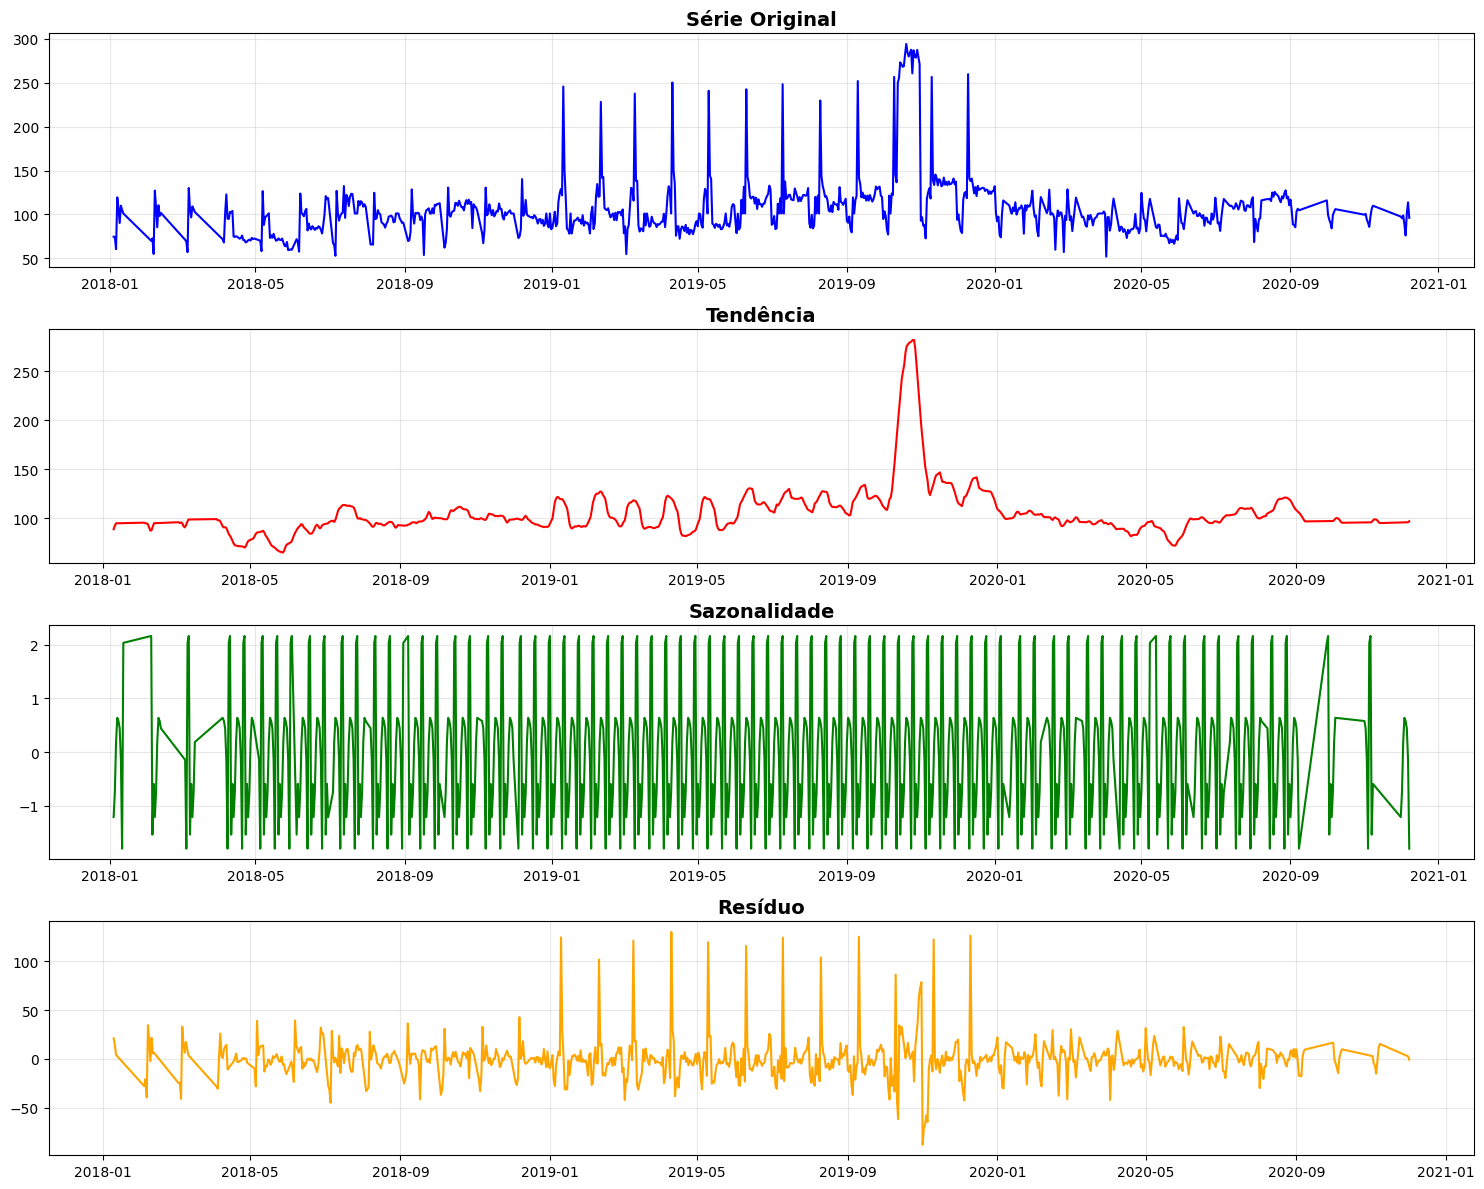

In [20]:
def decomposicao_serie(serie, periodo=12):
    """
    Decomp√µe a s√©rie em tend√™ncia, sazonalidade e res√≠duo
    """
    decomposicao = seasonal_decompose(serie, model='additive', period=periodo)
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # S√©rie original
    axes[0].plot(decomposicao.observed, color='blue')
    axes[0].set_title('S√©rie Original', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Tend√™ncia
    axes[1].plot(decomposicao.trend, color='red')
    axes[1].set_title('Tend√™ncia', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Sazonalidade
    axes[2].plot(decomposicao.seasonal, color='green')
    axes[2].set_title('Sazonalidade', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    # Res√≠duo
    axes[3].plot(decomposicao.resid, color='orange')
    axes[3].set_title('Res√≠duo', fontsize=14, fontweight='bold')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return decomposicao

# Decomposi√ß√£o das vendas
print("=== DECOMPOSI√á√ÉO DA S√âRIE DE VENDAS ===")
decomp_vendas = decomposicao_serie(df['Sale'])

=== DIVIS√ÉO DOS DADOS ===
Total de observa√ß√µes: 884
Dados de treino: 708 (80.1%)
Dados de teste: 176 (19.9%)
Per√≠odo de treino: 2018-01-04 00:00:00 at√© 2020-03-20 00:00:00
Per√≠odo de teste: 2020-03-21 00:00:00 at√© 2020-12-08 00:00:00

=== PREVIEW DOS DADOS DE TESTE ===
Primeiras 5 observa√ß√µes do conjunto de teste:
              Sale  Temperature
Date                           
2020-03-21  94.820        35.60
2020-03-22  87.450        36.36
2020-03-23  93.863        36.48
2020-03-24  96.107        35.67
2020-03-25  96.965        35.88

=== ESTAT√çSTICAS DESCRITIVAS DOS DADOS DE TESTE ===
Vendas - M√©dia: 97.62, Min: 51.79, Max: 127.40
Temperatura - M√©dia: 36.53, Min: 29.35, Max: 40.96

=== ESTAT√çSTICAS DESCRITIVAS DOS DADOS DE TREINO ===
Vendas - M√©dia: 108.78, Min: 52.76, Max: 294.29
Temperatura - M√©dia: 34.23, Min: 27.15, Max: 42.18


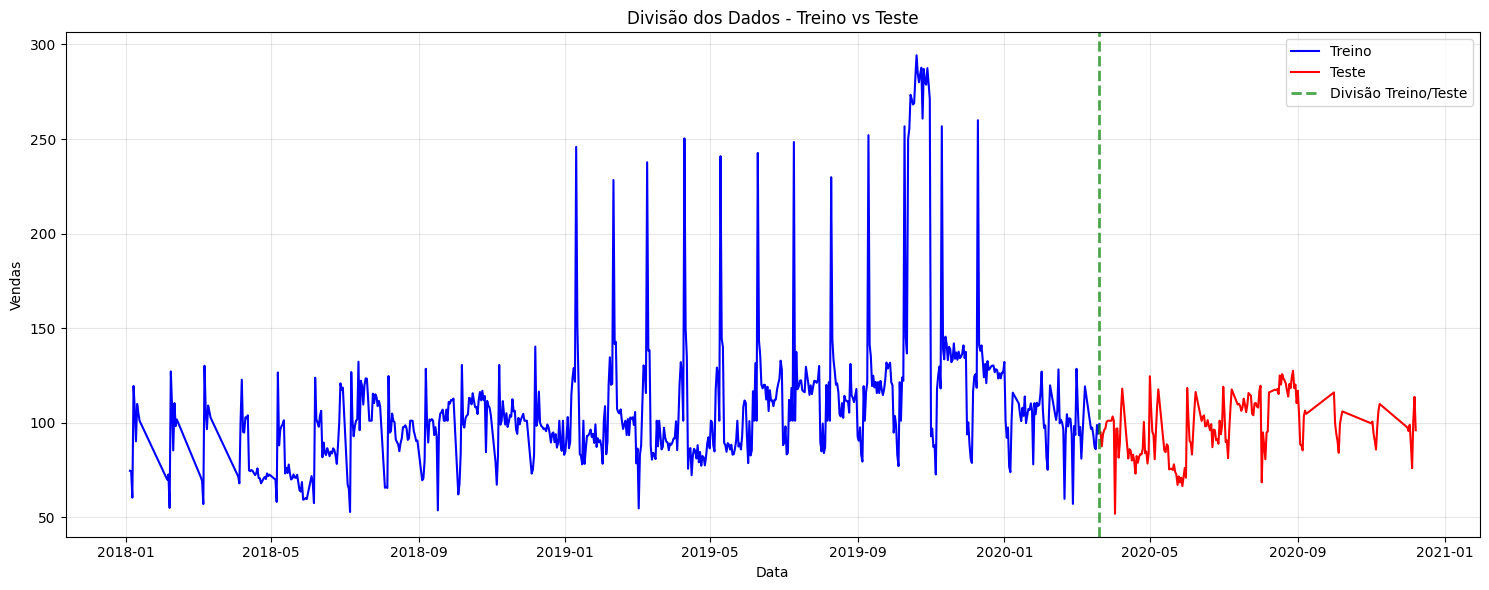

In [21]:
## Divis√£o dos Dados (Train/Test)
def dividir_dados_temporais(df, test_size=0.2):
    '''
    Divide os dados temporais em conjuntos de treino e teste.
    '''
    
    n_total = len(df)
    n_test = int(n_total * test_size)
    n_train = n_total - n_test
    
    # Divis√£o temporal (n√£o aleat√≥ria!)
    train_data = df.iloc[:n_train]
    test_data = df.iloc[n_train:]
    
    print(f"=== DIVIS√ÉO DOS DADOS ===")
    print(f"Total de observa√ß√µes: {n_total}")
    print(f"Dados de treino: {len(train_data)} ({len(train_data)/n_total*100:.1f}%)")
    print(f"Dados de teste: {len(test_data)} ({len(test_data)/n_total*100:.1f}%)")
    print(f"Per√≠odo de treino: {train_data.index.min()} at√© {train_data.index.max()}")
    print(f"Per√≠odo de teste: {test_data.index.min()} at√© {test_data.index.max()}")
    
    # Mostrar os valores de teste e predi√ß√£o
    print(f'\n=== PREVIEW DOS DADOS DE TESTE ===')
    print('Primeiras 5 observa√ß√µes do conjunto de teste:')
    print(test_data[['Sale', 'Temperature']].head())
    
    print('\n=== ESTAT√çSTICAS DESCRITIVAS DOS DADOS DE TESTE ===')
    print(f"Vendas - M√©dia: {test_data['Sale'].mean():.2f}, Min: {test_data['Sale'].min():.2f}, Max: {test_data['Sale'].max():.2f}")
    print(f"Temperatura - M√©dia: {test_data['Temperature'].mean():.2f}, Min: {test_data['Temperature'].min():.2f}, Max: {test_data['Temperature'].max():.2f}")
   
    print('\n=== ESTAT√çSTICAS DESCRITIVAS DOS DADOS DE TREINO ===')
    print(f"Vendas - M√©dia: {train_data['Sale'].mean():.2f}, Min: {train_data['Sale'].min():.2f}, Max: {train_data['Sale'].max():.2f}")
    print(f"Temperatura - M√©dia: {train_data['Temperature'].mean():.2f}, Min: {train_data['Temperature'].min():.2f}, Max: {train_data['Temperature'].max():.2f}")

    return train_data, test_data

# Dividir os dados
train_data, test_data = dividir_dados_temporais(df)

# Visualizar a divis√£o com linha de separa√ß√£o
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['Sale'], label='Treino', color='blue')
plt.plot(test_data.index, test_data['Sale'], label='Teste', color='red')

# Adicionar linha vertical para mostrar a divis√£o
plt.axvline(x=train_data.index[-1], color='green', linestyle='--', linewidth=2, alpha=0.7, label='Divis√£o Treino/Teste')

plt.title('Divis√£o dos Dados - Treino vs Teste')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5.0 - Time Series Modeling

## 5.0 - Advanced Feature Engineering

In [22]:
# Feature Engineering Avan√ßado
def create_temporal_features(df):
    """
    Cria features temporais avan√ßadas para modelagem
    """
    df_features = df.copy()
    
    # Features temporais b√°sicas
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['day_of_month'] = df_features.index.day
    df_features['day_of_year'] = df_features.index.dayofyear
    df_features['week_of_year'] = df_features.index.isocalendar().week
    df_features['quarter'] = df_features.index.quarter
    df_features['is_weekend'] = (df_features.index.dayofweek >= 5).astype(int)
    df_features['is_month_start'] = df_features.index.is_month_start.astype(int)
    df_features['is_month_end'] = df_features.index.is_month_end.astype(int)
    
    # Features c√≠clicas (para capturar sazonalidade)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['Month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['Month'] / 12)
    df_features['day_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['day_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
    
    # Lags (valores passados)
    for lag in [1, 2, 3, 7, 14, 30]:
        df_features[f'sale_lag_{lag}'] = df_features['Sale'].shift(lag)
        df_features[f'temp_lag_{lag}'] = df_features['Temperature'].shift(lag)
    
    # M√©dias m√≥veis
    for window in [3, 7, 14, 30]:
        df_features[f'sale_ma_{window}'] = df_features['Sale'].rolling(window=window).mean()
        df_features[f'temp_ma_{window}'] = df_features['Temperature'].rolling(window=window).mean()
    
    # Diferen√ßas (para capturar mudan√ßas)
    df_features['sale_diff_1'] = df_features['Sale'].diff()
    df_features['temp_diff_1'] = df_features['Temperature'].diff()
    
    # Estat√≠sticas rolantes
    df_features['sale_std_7'] = df_features['Sale'].rolling(window=7).std()
    df_features['sale_min_7'] = df_features['Sale'].rolling(window=7).min()
    df_features['sale_max_7'] = df_features['Sale'].rolling(window=7).max()
    
    # Intera√ß√µes
    df_features['sale_temp_interaction'] = df_features['Sale'] * df_features['Temperature']
    
    print(f"=== FEATURES CRIADAS ===")
    print(f"N√∫mero de features antes: {len(df.columns)}")
    print(f"N√∫mero de features depois: {len(df_features.columns)}")
    print(f"Novas features criadas: {len(df_features.columns) - len(df.columns)}")
    
    return df_features

# Criar features avan√ßadas
df_features = create_temporal_features(df)

# Mostrar as primeiras linhas das novas features
print("\n=== PREVIEW DAS NOVAS FEATURES ===")
new_features = [col for col in df_features.columns if col not in df.columns]
print(f"Algumas das novas features: {new_features[:10]}")
print(df_features[new_features[:5]].head())

=== FEATURES CRIADAS ===
N√∫mero de features antes: 4
N√∫mero de features depois: 42
Novas features criadas: 38

=== PREVIEW DAS NOVAS FEATURES ===
Algumas das novas features: ['day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'month_sin', 'month_cos']
            day_of_week  day_of_month  day_of_year  week_of_year  quarter
Date                                                                     
2018-01-04            3             4            4             1        1
2018-01-05            4             5            5             1        1
2018-01-06            5             6            6             1        1
2018-01-07            6             7            7             1        1
2018-01-08            0             8            8             2        1


In [23]:
# Baseline
def create_baseline_models(train_data, test_data):
    '''
    Cria modelos b√°sicos para compara√ß√£o
    '''
    
    # Separar apenas as vendas para modelagem
    y_train = train_data['Sale']
    y_test = test_data['Sale']
    
    # 1. Modelo Naive - prediz o √∫ltimo valor observado
    naive_pred = [y_train.iloc[-1]] * len(y_test)
    
    # 2.0 Modelo de M√©dia M√≥vel Simples (janela de 7 dias)
    window = 7
    moving_avg = [y_train.rolling(window=window).mean().iloc[-1]] * len(y_test)
    
    # 3. Modelo de M√©dia Hist√≥rica
    mean_pred = [y_train.mean()] * len(y_test)
    
    # 4. Modelo de Tend√™ncia Linear Simples
    from sklearn.linear_model import LinearRegression
    
    # Criar features temporais
    X_train = np.arange(len(y_train)).reshape(-1, 1)
    X_test = np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1, 1)
    
    # Treinar modelo linear
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    linear_pred = lr_model.predict(X_test)
    
    return {
        'naive': naive_pred,
        'moving_avg': moving_avg,
        'mean': mean_pred,
        'linear': linear_pred,
        'y_test': y_test
    }
    
# Criar modelos baseline
modelos_baseline = create_baseline_models(train_data, test_data)
    
print('Modelos baseline criados com sucesso!')

Modelos baseline criados com sucesso!



## 5.1 - Evaluate Models

In [24]:
# Fun√ß√£o para avaliar os modelos
def evaluate_model(y_true, y_pred, model_name):
    '''
    Calcula m√©tricas de erro para os modelos de s√©ries temporais
    '''
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f'=== {model_name} ===')
    print(f'MSE: {mse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')
    print('-' * 40)
    
    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Avaliar os modelos baseline
print('=== AVALIA√á√ÉO DOS MODELOS BASELINE ===')
resultados = {}

for nome, pred in modelos_baseline.items():
    if nome != 'y_test':
        resultados[nome] = evaluate_model(modelos_baseline['y_test'], pred, nome.upper())  

=== AVALIA√á√ÉO DOS MODELOS BASELINE ===
=== NAIVE ===
MSE: 229.43
MAE: 12.37
RMSE: 15.15
MAPE: 13.65%
----------------------------------------
=== MOVING_AVG ===
MSE: 241.74
MAE: 12.88
RMSE: 15.55
MAPE: 13.41%
----------------------------------------
=== MEAN ===
MSE: 351.18
MAE: 15.17
RMSE: 18.74
MAPE: 17.71%
----------------------------------------
=== LINEAR ===
MSE: 1876.73
MAE: 40.99
RMSE: 43.32
MAPE: 45.47%
----------------------------------------


## 5.2 - Visualize Baseline Model Predictions

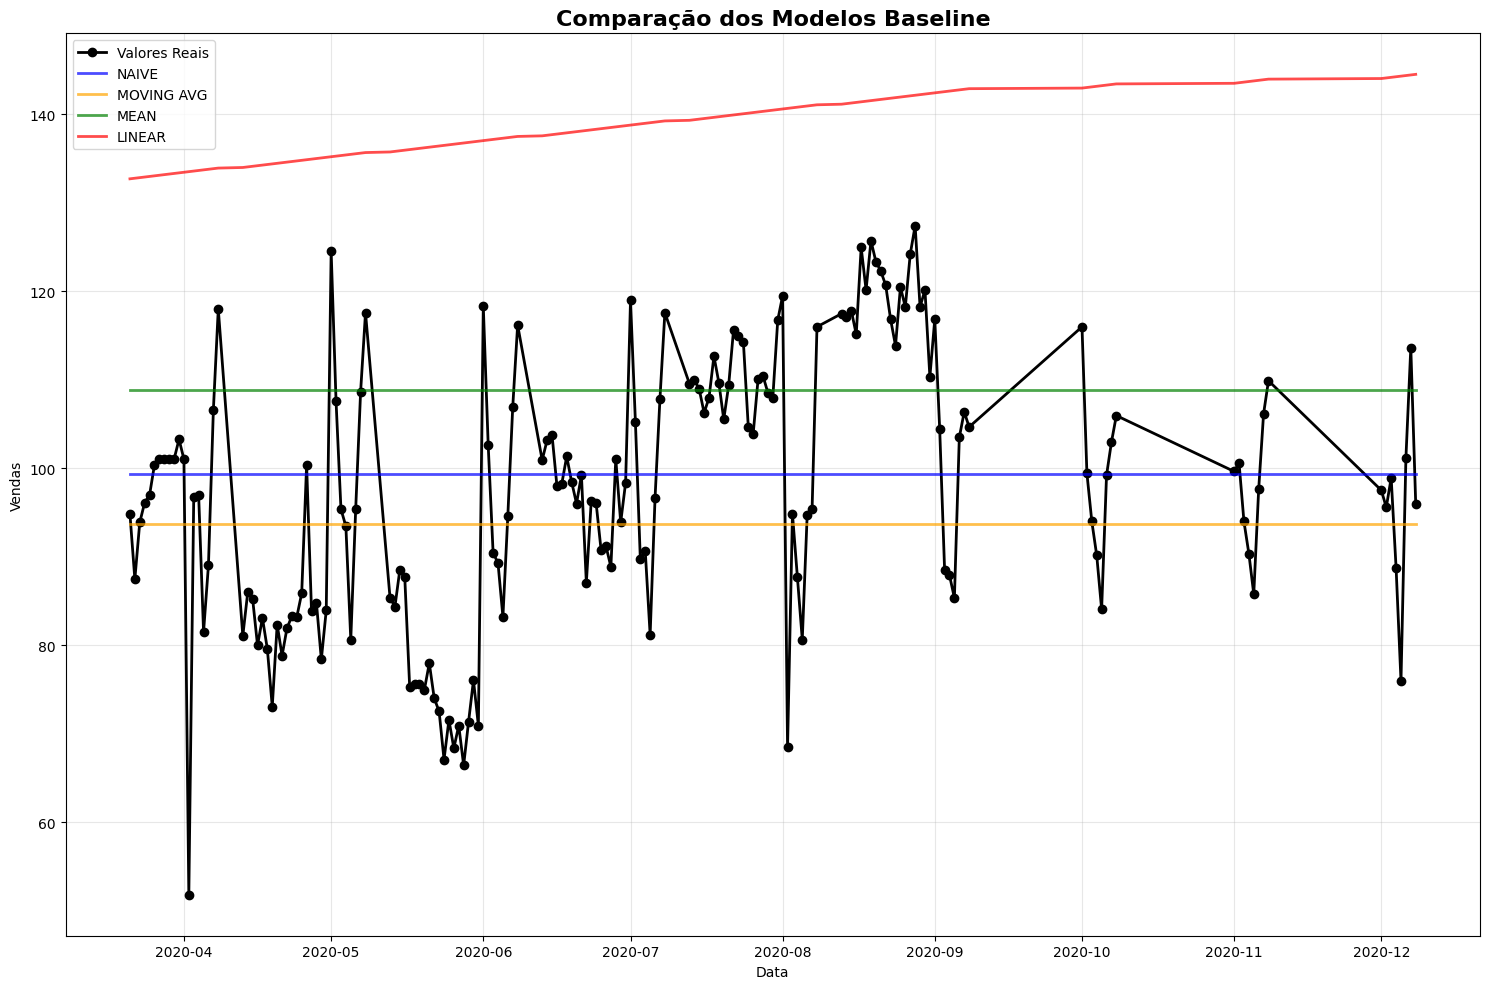

In [25]:
# Visualizar Previs√µes
def visualizar_previsoes_baseline(test_data, modelos_baseline):
    '''
    Visualiza as previs√µes dos modelos baseline
    '''
    
    plt.figure(figsize=(15, 10))
    
    # Dados reais
    plt.plot(test_data.index, test_data['Sale'],
             label='Valores Reais', color='black', linewidth=2, marker='o')
    
    # Previs√µes dos modelos
    cores = ['blue', 'orange', 'green', 'red']
    modelos_para_plot =  ['naive', 'moving_avg', 'mean', 'linear']
    
    for i, modelo in enumerate(modelos_para_plot):
        plt.plot(test_data.index, modelos_baseline[modelo],
                 label=modelo.upper().replace('_', ' '),
                 color=cores[i], linewidth=2, alpha=0.7)
        
    plt.title('Compara√ß√£o dos Modelos Baseline', fontsize=16, fontweight='bold')
    plt.xlabel('Data')
    plt.ylabel('Vendas')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualizar previs√µes
visualizar_previsoes_baseline(test_data, modelos_baseline)

## 5.3 - Results Summary

In [26]:
# Resumo dos Resultados
def resumo_resultados(resultados):
    '''
    Cria um resumo comparativo dos resultados
    '''
    
    df_resultados = pd.DataFrame(resultados).T
    df_resultados = df_resultados.round(2)
    
    print('\n=== RESUMO DOS RESULTADOS BASELINE ===')
    print(df_resultados.to_string())
    
    # Encontrar melhor modelo por m√©trica
    melhor_rmse = df_resultados['RMSE'].idxmin()
    melhor_mape = df_resultados['MAPE'].idxmin()
    
    print(f"MELHOR MODELO (RMSE): {melhor_rmse.upper()}")
    print(f"RMSE: {df_resultados.loc[melhor_rmse, 'RMSE']}")
    
    print(f'MELHOR MODELO (MAPE): {melhor_mape.upper()}')
    print(f"MAPE: {df_resultados.loc[melhor_mape, 'MAPE']}%")
    
    return df_resultados

# Mostrar resumo
df_resultados = resumo_resultados(resultados)


=== RESUMO DOS RESULTADOS BASELINE ===
                MSE    MAE   RMSE   MAPE
naive        229.43  12.37  15.15  13.65
moving_avg   241.74  12.88  15.55  13.41
mean         351.18  15.17  18.74  17.71
linear      1876.73  40.99  43.32  45.47
MELHOR MODELO (RMSE): NAIVE
RMSE: 15.15
MELHOR MODELO (MAPE): MOVING_AVG
MAPE: 13.41%


## 5.4 - ARIMA Model

=== MODELO ARIMA(1, 1, 1) ===
Treinando modelo ARIMA...

=== RESUMO DO MODELO ARIMA ===
AIC: 6585.90
BIC: 6599.58
Fazendo previs√µes...

=== PERFORMANCE ARIMA ===
MSE: 227.42
MAE: 12.37
RMSE: 15.08
MAPE: nan%


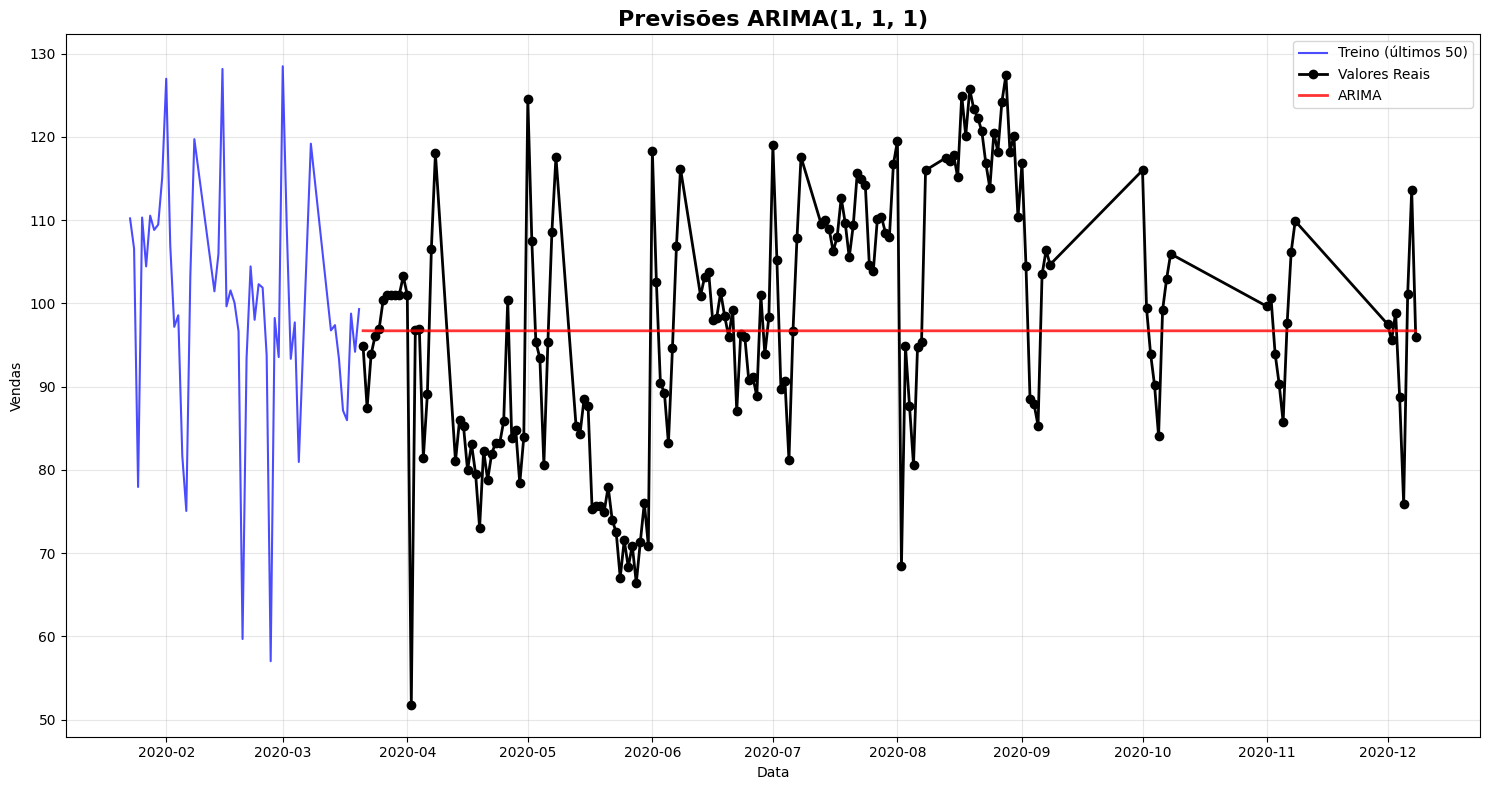

In [27]:
# Modelo ARIMA
def create_arima_model(train_data, test_data, order=(1,1,1)):
    """
    Cria e treina modelo ARIMA
    """
    print(f"=== MODELO ARIMA{order} ===")
    
    # Separar dados de treino
    y_train = train_data['Sale']
    y_test = test_data['Sale']
    
    try:
        # Criar e treinar modelo ARIMA
        print("Treinando modelo ARIMA...")
        modelo_arima = ARIMA(y_train, order=order)
        modelo_arima_fit = modelo_arima.fit()
        
        # Resumo do modelo
        print("\n=== RESUMO DO MODELO ARIMA ===")
        print(f"AIC: {modelo_arima_fit.aic:.2f}")
        print(f"BIC: {modelo_arima_fit.bic:.2f}")
        
        # Fazer previs√µes
        print("Fazendo previs√µes...")
        previsoes = modelo_arima_fit.forecast(steps=len(y_test))
        
        # Avaliar modelo
        mse = mean_squared_error(y_test, previsoes)
        mae = mean_absolute_error(y_test, previsoes)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - previsoes) / y_test)) * 100
        
        print(f"\n=== PERFORMANCE ARIMA ===")
        print(f"MSE: {mse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        
        # Visualizar previs√µes
        plt.figure(figsize=(15, 8))
        
        # √öltimos 50 pontos de treino para contexto
        plt.plot(y_train.index[-50:], y_train.iloc[-50:], label='Treino (√∫ltimos 50)', color='blue', alpha=0.7)
        plt.plot(y_test.index, y_test, label='Valores Reais', color='black', linewidth=2, marker='o')
        plt.plot(y_test.index, previsoes, label='ARIMA', color='red', linewidth=2, alpha=0.8)
        
        plt.title(f'Previs√µes ARIMA{order}', fontsize=16, fontweight='bold')
        plt.xlabel('Data')
        plt.ylabel('Vendas')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return modelo_arima_fit, previsoes, {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
        
    except Exception as e:
        print(f"Erro ao criar modelo ARIMA: {e}")
        return None, None, None

# Criar modelo ARIMA
modelo_arima, previsoes_arima, resultados_arima = create_arima_model(train_data, test_data)

# Adicionar resultados ARIMA ao dicion√°rio de resultados
if resultados_arima:
    resultados['arima'] = resultados_arima

### 5.4.1 - ARIMA Problem Diagnosis

üîç DIAGNOSTICANDO O PROBLEMA DO ARIMA...
üîß ARIMA PROBLEM DIAGNOSIS

üìä 1. CHECKING STATIONARITY:
----------------------------------------
Original Series:
   ‚Ä¢ Estat√≠stica ADF: -4.1994
   ‚Ä¢ P-valor: 0.000660
   ‚Ä¢ Estacion√°ria: ‚úÖ SIM

Ap√≥s 1¬™ Diferencia√ß√£o:
   ‚Ä¢ Estat√≠stica ADF: -12.8580
   ‚Ä¢ P-valor: 0.000000
   ‚Ä¢ Estacion√°ria: ‚úÖ SIM


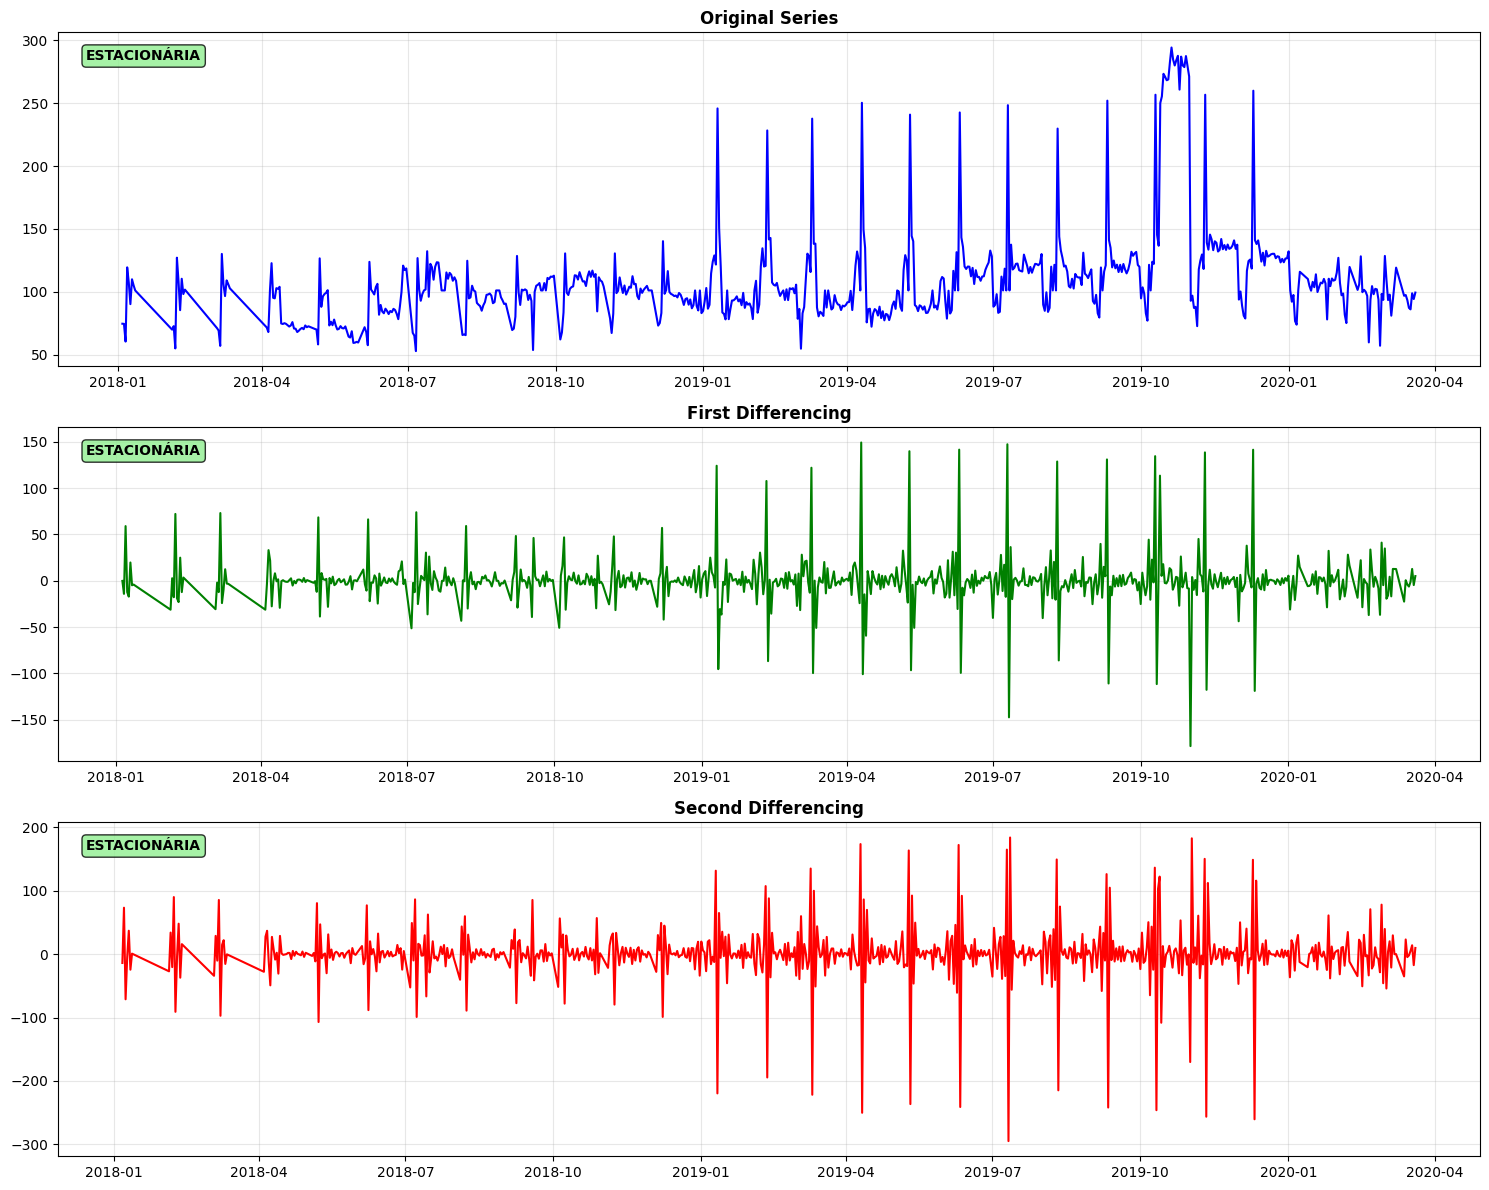


Second Differencing:
   ‚Ä¢ Estat√≠stica ADF: -11.2631
   ‚Ä¢ P-valor: 0.000000
   ‚Ä¢ Estacion√°ria: ‚úÖ SIM

üéØ 3. RECOMENDA√á√ÉO PARA DIFERENCIA√á√ÉO (d):
--------------------------------------------------
   ‚Ä¢ d = 0 (series already stationary)

‚ùó 4. WHY ARIMA WAS GENERATING STRAIGHT LINE:
-------------------------------------------------------
   ‚Ä¢ üéØ Inadequate parameters (p,d,q) = (1,1,1)
   ‚Ä¢ üìä Series may not need differencing d=1
   ‚Ä¢ üîÑ Model 'stuck' at average value due to poor convergence
   ‚Ä¢ üìà Simple ARIMA doesn't capture complex variations
   ‚Ä¢ üé∞ Need to test multiple parameter combinations


In [28]:
def diagnose_arima_problem(train_data, test_data):
    """
    Diagnostica e corrige problemas do ARIMA
    """
    print("="*70)
    print("üîß ARIMA PROBLEM DIAGNOSIS")
    print("="*70)
    
    y_train = train_data['Sale']
    y_test = test_data['Sale']
    
    # 1. Verificar estacionariedade
    print("\nüìä 1. CHECKING STATIONARITY:")
    print("-" * 40)
    
    # Teste ADF na s√©rie original
    resultado_original = adfuller(y_train.dropna())
    
    print(f"Original Series:")
    print(f"   ‚Ä¢ Estat√≠stica ADF: {resultado_original[0]:.4f}")
    print(f"   ‚Ä¢ P-valor: {resultado_original[1]:.6f}")
    print(f"   ‚Ä¢ Estacion√°ria: {'‚úÖ SIM' if resultado_original[1] <= 0.05 else '‚ùå N√ÉO'}")
    
    # Teste ap√≥s primeira diferencia√ß√£o
    y_diff1 = y_train.diff().dropna()
    resultado_diff1 = adfuller(y_diff1)
    
    print(f"\nAp√≥s 1¬™ Diferencia√ß√£o:")
    print(f"   ‚Ä¢ Estat√≠stica ADF: {resultado_diff1[0]:.4f}")
    print(f"   ‚Ä¢ P-valor: {resultado_diff1[1]:.6f}")
    print(f"   ‚Ä¢ Estacion√°ria: {'‚úÖ SIM' if resultado_diff1[1] <= 0.05 else '‚ùå N√ÉO'}")
    
    # 2. Visualizar diferencia√ß√µes
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # S√©rie original
    axes[0].plot(y_train.index, y_train, color='blue')
    axes[0].set_title('Original Series', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    if resultado_original[1] <= 0.05:
        axes[0].text(0.02, 0.95, 'ESTACION√ÅRIA', transform=axes[0].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
                    verticalalignment='top', fontweight='bold')
    else:
        axes[0].text(0.02, 0.95, 'N√ÉO ESTACION√ÅRIA', transform=axes[0].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
                    verticalalignment='top', fontweight='bold')
    
    # Primeira diferencia√ß√£o
    axes[1].plot(y_diff1.index, y_diff1, color='green')
    axes[1].set_title('First Differencing', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    if resultado_diff1[1] <= 0.05:
        axes[1].text(0.02, 0.95, 'ESTACION√ÅRIA', transform=axes[1].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
                    verticalalignment='top', fontweight='bold')
    else:
        axes[1].text(0.02, 0.95, 'N√ÉO ESTACION√ÅRIA', transform=axes[1].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
                    verticalalignment='top', fontweight='bold')
    
    # Segunda diferencia√ß√£o (se necess√°rio)
    y_diff2 = y_diff1.diff().dropna()
    resultado_diff2 = adfuller(y_diff2)
    
    axes[2].plot(y_diff2.index, y_diff2, color='red')
    axes[2].set_title('Second Differencing', fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    if resultado_diff2[1] <= 0.05:
        axes[2].text(0.02, 0.95, 'ESTACION√ÅRIA', transform=axes[2].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
                    verticalalignment='top', fontweight='bold')
    else:
        axes[2].text(0.02, 0.95, 'N√ÉO ESTACION√ÅRIA', transform=axes[2].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
                    verticalalignment='top', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSecond Differencing:")
    print(f"   ‚Ä¢ Estat√≠stica ADF: {resultado_diff2[0]:.4f}")
    print(f"   ‚Ä¢ P-valor: {resultado_diff2[1]:.6f}")
    print(f"   ‚Ä¢ Estacion√°ria: {'‚úÖ SIM' if resultado_diff2[1] <= 0.05 else '‚ùå N√ÉO'}")
    
    # 3. Determinar melhor valor de 'd'
    print(f"\nüéØ 3. RECOMENDA√á√ÉO PARA DIFERENCIA√á√ÉO (d):")
    print("-" * 50)
    
    if resultado_original[1] <= 0.05:
        d_recommended = 0
        print(f"   ‚Ä¢ d = 0 (series already stationary)")
    elif resultado_diff1[1] <= 0.05:
        d_recommended = 1
        print(f"   ‚Ä¢ d = 1 (first differencing sufficient)")
    elif resultado_diff2[1] <= 0.05:
        d_recommended = 2
        print(f"   ‚Ä¢ d = 2 (second differencing necessary)")
    else:
        d_recommended = 1
        print(f"   ‚Ä¢ d = 1 (use first differencing anyway)")
    
    # 4. Explain straight line problem
    print(f"\n‚ùó 4. WHY ARIMA WAS GENERATING STRAIGHT LINE:")
    print("-" * 55)
    print(f"   ‚Ä¢ üéØ Inadequate parameters (p,d,q) = (1,1,1)")
    print(f"   ‚Ä¢ üìä Series may not need differencing d=1")
    print(f"   ‚Ä¢ üîÑ Model 'stuck' at average value due to poor convergence")
    print(f"   ‚Ä¢ üìà Simple ARIMA doesn't capture complex variations")
    print(f"   ‚Ä¢ üé∞ Need to test multiple parameter combinations")
    
    return d_recommended

# Executar diagn√≥stico
print("üîç DIAGNOSTICANDO O PROBLEMA DO ARIMA...")
d_otimo = diagnose_arima_problem(train_data, test_data)

In [29]:
def create_optimized_arima(train_data, test_data, d_recommended=1, max_attempts=5):
    """
    Cria e testa m√∫ltiplos modelos ARIMA para encontrar o melhor
    """
    print("\n" + "="*70)
    print("üöÄ CRIANDO ARIMA OTIMIZADO")
    print("="*70)
    
    y_train = train_data['Sale']
    y_test = test_data['Sale']
    
    # Parameters to test
    test_parameters = [
        (0, d_recommended, 1),   # Simple MA
        (1, d_recommended, 0),   # Simple AR
        (1, d_recommended, 1),   # Classic ARIMA
        (2, d_recommended, 1),   # Enhanced AR
        (1, d_recommended, 2),   # Enhanced MA
        (2, d_recommended, 2),   # Complex model
        (3, d_recommended, 1),   # More complex AR
        (1, d_recommended, 3),   # More complex MA
    ]
    
    resultados = []
    
    print(f"\nüîÑ TESTING {len(test_parameters)} PARAMETER COMBINATIONS:")
    print("-" * 60)
    
    for i, (p, d, q) in enumerate(test_parameters, 1):
        try:
            print(f"\n{i}. Testando ARIMA({p},{d},{q})...")
            
            # Treinar modelo
            modelo = ARIMA(y_train, order=(p, d, q))
            modelo_fit = modelo.fit()
            
            # Fazer previs√µes
            previsoes = modelo_fit.forecast(steps=len(y_test))
            
            # Calcular m√©tricas
            mae = mean_absolute_error(y_test, previsoes)
            mse = mean_squared_error(y_test, previsoes)
            rmse = np.sqrt(mse)
            
            # Verificar se prev√™ linha reta
            variancia_previsao = np.var(previsoes)
            eh_linha_reta = variancia_previsao < 1.0
            
            resultado = {
                'parametros': f"({p},{d},{q})",
                'p': p, 'd': d, 'q': q,
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'aic': modelo_fit.aic,
                'bic': modelo_fit.bic,
                'variancia_previsao': variancia_previsao,
                'linha_reta': eh_linha_reta,
                'modelo': modelo_fit,
                'previsoes': previsoes
            }
            
            resultados.append(resultado)
            
            status = "‚ùå LINHA RETA" if eh_linha_reta else "‚úÖ VARIA√á√ÉO"
            print(f"   ‚Ä¢ MAE: {mae:.2f} | RMSE: {rmse:.2f} | AIC: {modelo_fit.aic:.2f} | {status}")
            
        except Exception as e:
            print(f"   ‚Ä¢ ‚ùå ERRO: {str(e)}")
            continue
    
    if not resultados:
        print("‚ùå NENHUM MODELO FUNCIONOU!")
        return None, None, None
    
    # Encontrar melhor modelo (menor MAE, sem ser linha reta)
    modelos_validos = [r for r in resultados if not r['linha_reta']]
    
    if modelos_validos:
        melhor = min(modelos_validos, key=lambda x: x['mae'])
        print(f"\nüèÜ MELHOR MODELO (sem linha reta): ARIMA{melhor['parametros']}")
    else:
        melhor = min(resultados, key=lambda x: x['mae'])
        print(f"\n‚ö†Ô∏è  MELHOR MODELO (todos geram linha reta): ARIMA{melhor['parametros']}")
        print(f"   (Problema pode estar nos dados ou s√©rie muito dif√≠cil de prever)")
    
    print(f"   ‚Ä¢ MAE: {melhor['mae']:.2f}")
    print(f"   ‚Ä¢ RMSE: {melhor['rmse']:.2f}")
    print(f"   ‚Ä¢ AIC: {melhor['aic']:.2f}")
    print(f"   ‚Ä¢ Vari√¢ncia previs√£o: {melhor['variancia_previsao']:.2f}")
    
    # Mostrar tabela comparativa
    print(f"\nüìä COMPARA√á√ÉO DE TODOS OS MODELOS:")
    print("-" * 70)
    print(f"{'Modelo':<12} {'MAE':<8} {'RMSE':<8} {'AIC':<8} {'Vari√¢ncia':<10} {'Status'}")
    print("-" * 70)
    
    for r in sorted(resultados, key=lambda x: x['mae']):
        status = "Linha Reta" if r['linha_reta'] else "Varia√ß√£o"
        print(f"ARIMA{r['parametros']:<7} {r['mae']:<8.2f} {r['rmse']:<8.2f} {r['aic']:<8.2f} {r['variancia_previsao']:<10.2f} {status}")
    
    return melhor['modelo'], melhor['previsoes'], melhor

# Criar modelo ARIMA otimizado
print("üéØ CRIANDO ARIMA OTIMIZADO...")
modelo_arima_otimo, previsoes_arima_otimo, info_melhor_arima = create_optimized_arima(train_data, test_data, d_otimo)

üéØ CRIANDO ARIMA OTIMIZADO...

üöÄ CRIANDO ARIMA OTIMIZADO

üîÑ TESTING 8 PARAMETER COMBINATIONS:
------------------------------------------------------------

1. Testando ARIMA(0,0,1)...
   ‚Ä¢ MAE: 15.16 | RMSE: 18.73 | AIC: 6914.71 | ‚ùå LINHA RETA

2. Testando ARIMA(1,0,0)...
   ‚Ä¢ MAE: 14.95 | RMSE: 18.55 | AIC: 6646.96 | ‚ùå LINHA RETA

3. Testando ARIMA(1,0,1)...
   ‚Ä¢ MAE: 14.95 | RMSE: 18.55 | AIC: 6646.96 | ‚ùå LINHA RETA

3. Testando ARIMA(1,0,1)...
   ‚Ä¢ MAE: 14.32 | RMSE: 17.99 | AIC: 6569.13 | ‚úÖ VARIA√á√ÉO

4. Testando ARIMA(2,0,1)...
   ‚Ä¢ MAE: 14.65 | RMSE: 18.37 | AIC: 6569.12 | ‚úÖ VARIA√á√ÉO

5. Testando ARIMA(1,0,2)...
   ‚Ä¢ MAE: 14.32 | RMSE: 17.99 | AIC: 6569.13 | ‚úÖ VARIA√á√ÉO

4. Testando ARIMA(2,0,1)...
   ‚Ä¢ MAE: 14.65 | RMSE: 18.37 | AIC: 6569.12 | ‚úÖ VARIA√á√ÉO

5. Testando ARIMA(1,0,2)...
   ‚Ä¢ MAE: 14.65 | RMSE: 18.38 | AIC: 6569.22 | ‚úÖ VARIA√á√ÉO

6. Testando ARIMA(2,0,2)...
   ‚Ä¢ MAE: 14.65 | RMSE: 18.38 | AIC: 6569.22 | ‚úÖ VARIA√á√ÉO



üìà VISUALIZANDO ARIMA OTIMIZADO


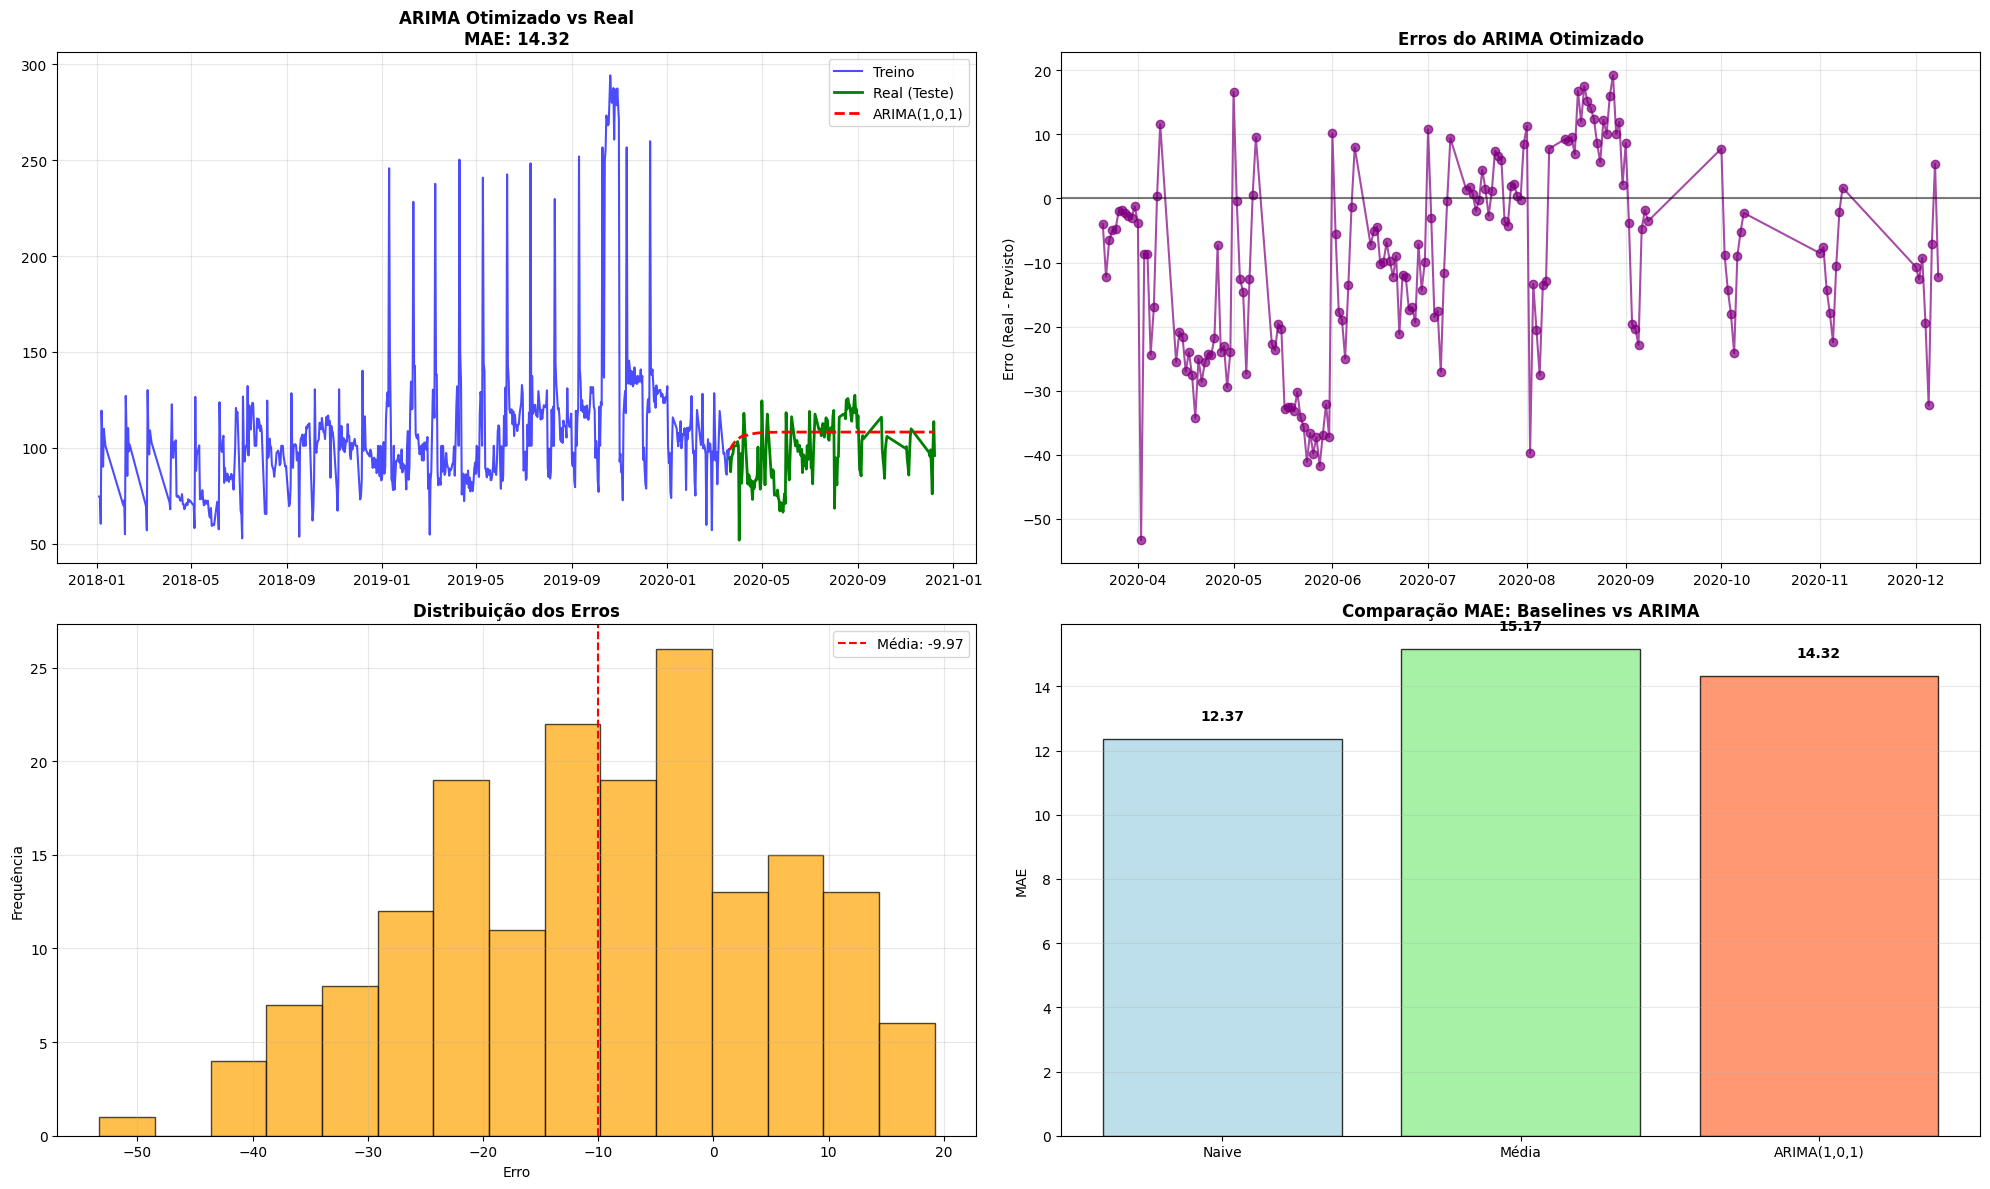


üéØ AN√ÅLISE DE PERFORMANCE:
----------------------------------------
   ‚Ä¢ MAE Naive: 12.37
   ‚Ä¢ MAE M√©dia: 15.17
   ‚Ä¢ MAE ARIMA: 14.32
   ‚Ä¢ Melhoria vs Naive: -15.7%
   ‚Ä¢ Melhoria vs M√©dia: 5.6%
   ‚Ä¢ ‚ùå ARIMA pior que baseline simples

üí° RESUMO DO ARIMA OTIMIZADO:
   ‚Ä¢ Modelo escolhido: ARIMA(1,0,1)
   ‚Ä¢ Erro m√©dio: 14.32 unidades de venda
   ‚Ä¢ Vari√¢ncia das previs√µes: 2.58
   ‚Ä¢ Status: ‚úÖ Gera varia√ß√£o


In [30]:
# Visualizar resultado do ARIMA otimizado
if modelo_arima_otimo is not None:
    print("\n" + "="*70)
    print("üìà VISUALIZANDO ARIMA OTIMIZADO")
    print("="*70)
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Compara√ß√£o das previs√µes
    axes[0,0].plot(train_data.index, train_data['Sale'], label='Treino', color='blue', alpha=0.7)
    axes[0,0].plot(test_data.index, test_data['Sale'], label='Real (Teste)', color='green', linewidth=2)
    axes[0,0].plot(test_data.index, previsoes_arima_otimo, label=f'ARIMA{info_melhor_arima["parametros"]}', color='red', linewidth=2, linestyle='--')
    axes[0,0].set_title(f'ARIMA Otimizado vs Real\nMAE: {info_melhor_arima["mae"]:.2f}', fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Erro ao longo do tempo
    erros = test_data['Sale'].values - previsoes_arima_otimo
    axes[0,1].plot(test_data.index, erros, color='purple', marker='o', alpha=0.7)
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0,1].set_title('Erros do ARIMA Otimizado', fontweight='bold')
    axes[0,1].set_ylabel('Erro (Real - Previsto)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Distribui√ß√£o dos erros
    axes[1,0].hist(erros, bins=15, alpha=0.7, color='orange', edgecolor='black')
    axes[1,0].axvline(np.mean(erros), color='red', linestyle='--', label=f'M√©dia: {np.mean(erros):.2f}')
    axes[1,0].set_title('Distribui√ß√£o dos Erros', fontweight='bold')
    axes[1,0].set_xlabel('Erro')
    axes[1,0].set_ylabel('Frequ√™ncia')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Compara√ß√£o com baseline
    y_test = test_data['Sale']
    mae_naive = mean_absolute_error(y_test, [train_data['Sale'].iloc[-1]] * len(y_test))
    mae_media = mean_absolute_error(y_test, [train_data['Sale'].mean()] * len(y_test))
    mae_arima = info_melhor_arima['mae']
    
    modelos_comp = ['Naive', 'M√©dia', f'ARIMA{info_melhor_arima["parametros"]}']
    maes_comp = [mae_naive, mae_media, mae_arima]
    cores = ['lightblue', 'lightgreen', 'coral']
    
    bars = axes[1,1].bar(modelos_comp, maes_comp, color=cores, alpha=0.8, edgecolor='black')
    axes[1,1].set_title('Compara√ß√£o MAE: Baselines vs ARIMA', fontweight='bold')
    axes[1,1].set_ylabel('MAE')
    
    # Adicionar valores nas barras
    for bar, mae in zip(bars, maes_comp):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                      f'{mae:.2f}', ha='center', va='bottom', fontweight='bold')
    
    axes[1,1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # An√°lise de melhoria
    melhoria_naive = ((mae_naive - mae_arima) / mae_naive) * 100
    melhoria_media = ((mae_media - mae_arima) / mae_media) * 100
    
    print(f"\nüéØ AN√ÅLISE DE PERFORMANCE:")
    print("-" * 40)
    print(f"   ‚Ä¢ MAE Naive: {mae_naive:.2f}")
    print(f"   ‚Ä¢ MAE M√©dia: {mae_media:.2f}")
    print(f"   ‚Ä¢ MAE ARIMA: {mae_arima:.2f}")
    print(f"   ‚Ä¢ Melhoria vs Naive: {melhoria_naive:.1f}%")
    print(f"   ‚Ä¢ Melhoria vs M√©dia: {melhoria_media:.1f}%")
    
    if melhoria_naive > 10:
        print(f"   ‚Ä¢ ‚úÖ ARIMA muito melhor que baseline!")
    elif melhoria_naive > 0:
        print(f"   ‚Ä¢ ‚úÖ ARIMA melhor que baseline")
    else:
        print(f"   ‚Ä¢ ‚ùå ARIMA pior que baseline simples")
        
    print(f"\nüí° RESUMO DO ARIMA OTIMIZADO:")
    print(f"   ‚Ä¢ Modelo escolhido: ARIMA{info_melhor_arima['parametros']}")
    print(f"   ‚Ä¢ Erro m√©dio: {mae_arima:.2f} unidades de venda")
    print(f"   ‚Ä¢ Vari√¢ncia das previs√µes: {info_melhor_arima['variancia_previsao']:.2f}")
    print(f"   ‚Ä¢ Status: {'‚úÖ Gera varia√ß√£o' if not info_melhor_arima['linha_reta'] else '‚ùå Linha reta'}")

else:
    print("‚ùå ARIMA otimizado n√£o foi criado - verifique erros anteriores!")

## 5.5 - Advanced Time Series Models
- **SARIMA**: ARIMA with seasonal component
- **Exponential Smoothing**: Method that gives more weight to recent observations
- **Prophet**: Facebook's model for time series

In [ ]:
# 5.5.1 - SARIMA Model (ARIMA + Seasonality)

def create_optimized_sarima(train_data, test_data):
    """
    Cria modelo SARIMA otimizado para capturar sazonalidade
    """
    print("="*70)
    print("üîÑ CRIANDO MODELO SARIMA")
    print("="*70)
    
    y_train = train_data['Sale']
    y_test = test_data['Sale']
    
    # Par√¢metros SARIMA para testar (p,d,q)(P,D,Q,s)
    # s=7 para sazonalidade semanal (assumindo dados di√°rios)
    parametros_sarima = [
        ((1,1,1), (1,1,1,7)),   # Sazonalidade semanal
        ((1,1,1), (0,1,1,7)),   # Sem AR sazonal
        ((2,1,1), (1,1,1,7)),   # AR aumentado
        ((1,1,2), (1,1,1,7)),   # MA aumentado
        ((1,1,1), (1,1,1,30)),  # Sazonalidade mensal
    ]
    
    resultados_sarima = []
    
    print(f"\nüîÑ TESTANDO {len(parametros_sarima)} CONFIGURA√á√ïES SARIMA:")
    print("-" * 60)
    
    for i, (ordem, ordem_sazonal) in enumerate(parametros_sarima, 1):
        try:
            p, d, q = ordem
            P, D, Q, s = ordem_sazonal
            
            print(f"\n{i}. Testando SARIMA({p},{d},{q})x({P},{D},{Q},{s})...")
            
            # Criar e treinar modelo
            modelo = SARIMAX(y_train, 
                           order=ordem,
                           seasonal_order=ordem_sazonal,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
            
            modelo_fit = modelo.fit(disp=False)
            
            # Fazer previs√µes
            previsoes = modelo_fit.forecast(steps=len(y_test))
            
            # Calcular m√©tricas
            mae = mean_absolute_error(y_test, previsoes)
            mse = mean_squared_error(y_test, previsoes)
            rmse = np.sqrt(mse)
            
            # Verificar varia√ß√£o
            variancia_previsao = np.var(previsoes)
            eh_linha_reta = variancia_previsao < 1.0
            
            resultado = {
                'modelo_nome': f"SARIMA({p},{d},{q})x({P},{D},{Q},{s})",
                'ordem': ordem,
                'ordem_sazonal': ordem_sazonal,
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'aic': modelo_fit.aic,
                'bic': modelo_fit.bic,
                'variancia_previsao': variancia_previsao,
                'linha_reta': eh_linha_reta,
                'modelo': modelo_fit,
                'previsoes': previsoes
            }
            
            resultados_sarima.append(resultado)
            
            status = "‚ùå LINHA RETA" if eh_linha_reta else "‚úÖ VARIA√á√ÉO"
            print(f"   ‚Ä¢ MAE: {mae:.2f} | RMSE: {rmse:.2f} | AIC: {modelo_fit.aic:.2f} | {status}")
            
        except Exception as e:
            print(f"   ‚Ä¢ ‚ùå ERRO: {str(e)[:50]}...")
            continue
    
    if not resultados_sarima:
        print("‚ùå NENHUM MODELO SARIMA FUNCIONOU!")
        return None, None, None
    
    # Encontrar melhor modelo
    modelos_validos = [r for r in resultados_sarima if not r['linha_reta']]
    
    if modelos_validos:
        melhor_sarima = min(modelos_validos, key=lambda x: x['mae'])
        print(f"\nüèÜ MELHOR SARIMA: {melhor_sarima['modelo_nome']}")
    else:
        melhor_sarima = min(resultados_sarima, key=lambda x: x['mae'])
        print(f"\n‚ö†Ô∏è  MELHOR SARIMA: {melhor_sarima['modelo_nome']} (linha reta)")
    
    print(f"   ‚Ä¢ MAE: {melhor_sarima['mae']:.2f}")
    print(f"   ‚Ä¢ RMSE: {melhor_sarima['rmse']:.2f}")
    print(f"   ‚Ä¢ AIC: {melhor_sarima['aic']:.2f}")
    
    return melhor_sarima['modelo'], melhor_sarima['previsoes'], melhor_sarima

print("üéØ CRIANDO MODELO SARIMA...")
modelo_sarima, previsoes_sarima, info_sarima = create_optimized_sarima(train_data, test_data)

üéØ CRIANDO MODELO SARIMA...
üîÑ CRIANDO MODELO SARIMA

üîÑ TESTANDO 5 CONFIGURA√á√ïES SARIMA:
------------------------------------------------------------

1. Testando SARIMA(1,1,1)x(1,1,1,7)...
   ‚Ä¢ MAE: 12.22 | RMSE: 14.81 | AIC: 6471.77 | ‚úÖ VARIA√á√ÉO

2. Testando SARIMA(1,1,1)x(0,1,1,7)...
   ‚Ä¢ MAE: 12.22 | RMSE: 14.81 | AIC: 6471.77 | ‚úÖ VARIA√á√ÉO

2. Testando SARIMA(1,1,1)x(0,1,1,7)...
   ‚Ä¢ MAE: 12.11 | RMSE: 14.67 | AIC: 6470.36 | ‚úÖ VARIA√á√ÉO

3. Testando SARIMA(2,1,1)x(1,1,1,7)...
   ‚Ä¢ MAE: 12.11 | RMSE: 14.67 | AIC: 6470.36 | ‚úÖ VARIA√á√ÉO

3. Testando SARIMA(2,1,1)x(1,1,1,7)...
   ‚Ä¢ MAE: 13.02 | RMSE: 16.18 | AIC: 6450.65 | ‚úÖ VARIA√á√ÉO

4. Testando SARIMA(1,1,2)x(1,1,1,7)...
   ‚Ä¢ MAE: 13.02 | RMSE: 16.18 | AIC: 6450.65 | ‚úÖ VARIA√á√ÉO

4. Testando SARIMA(1,1,2)x(1,1,1,7)...
   ‚Ä¢ MAE: 12.11 | RMSE: 14.68 | AIC: 6460.47 | ‚úÖ VARIA√á√ÉO

5. Testando SARIMA(1,1,1)x(1,1,1,30)...
   ‚Ä¢ MAE: 12.11 | RMSE: 14.68 | AIC: 6460.47 | ‚úÖ VARIA√á√ÉO

5. Test

   ‚Ä¢ MAE: 21.54 | RMSE: 26.14 | AIC: 6078.70 | ‚úÖ VARIA√á√ÉO

üèÜ MELHOR SARIMA: SARIMA(1,1,2)x(1,1,1,7)
   ‚Ä¢ MAE: 12.11
   ‚Ä¢ RMSE: 14.68
   ‚Ä¢ AIC: 6460.47


In [ ]:
def create_exponential_smoothing(train_data, test_data):
    """
    Implementa diferentes tipos de suaviza√ß√£o exponencial
    """
    print("\n" + "="*70)
    print("üìä CRIANDO MODELOS DE SUAVIZA√á√ÉO EXPONENCIAL")
    print("="*70)
    
    y_train = train_data['Sale']
    y_test = test_data['Sale']
    
    modelos_exp = []
    
    # 1. Suaviza√ß√£o Simples
    print("\n1. Suaviza√ß√£o Exponencial Simples...")
    try:
        modelo_simples = ExponentialSmoothing(y_train, trend=None, seasonal=None)
        fit_simples = modelo_simples.fit()
        prev_simples = fit_simples.forecast(len(y_test))
        
        mae_simples = mean_absolute_error(y_test, prev_simples)
        modelos_exp.append({
            'nome': 'Exp. Simples',
            'modelo': fit_simples,
            'previsoes': prev_simples,
            'mae': mae_simples,
            'tipo': 'simples'
        })
        print(f"   ‚Ä¢ MAE: {mae_simples:.2f}")
    except Exception as e:
        print(f"   ‚Ä¢ ‚ùå ERRO: {e}")
    
    # 2. Suaviza√ß√£o com Tend√™ncia (Holt)
    print("\n2. Suaviza√ß√£o com Tend√™ncia (Holt)...")
    try:
        modelo_holt = ExponentialSmoothing(y_train, trend='add', seasonal=None)
        fit_holt = modelo_holt.fit()
        prev_holt = fit_holt.forecast(len(y_test))
        
        mae_holt = mean_absolute_error(y_test, prev_holt)
        modelos_exp.append({
            'nome': 'Holt (Tend√™ncia)',
            'modelo': fit_holt,
            'previsoes': prev_holt,
            'mae': mae_holt,
            'tipo': 'holt'
        })
        print(f"   ‚Ä¢ MAE: {mae_holt:.2f}")
    except Exception as e:
        print(f"   ‚Ä¢ ‚ùå ERRO: {e}")
    
    # 3. Holt-Winters com Sazonalidade
    if len(y_train) >= 14:  # Precisa de pelo menos 2 ciclos sazonais
        print("\n3. Holt-Winters (Tend√™ncia + Sazonalidade)...")
        
        for tipo_sazonal in ['add', 'mul']:
            for periodo in [7, 10]:  # Tentar diferentes per√≠odos sazonais
                try:
                    modelo_hw = ExponentialSmoothing(y_train, 
                                                   trend='add', 
                                                   seasonal=tipo_sazonal,
                                                   seasonal_periods=periodo)
                    fit_hw = modelo_hw.fit()
                    prev_hw = fit_hw.forecast(len(y_test))
                    
                    mae_hw = mean_absolute_error(y_test, prev_hw)
                    
                    nome = f'Holt-Winters ({tipo_sazonal}, s={periodo})'
                    modelos_exp.append({
                        'nome': nome,
                        'modelo': fit_hw,
                        'previsoes': prev_hw,
                        'mae': mae_hw,
                        'tipo': f'holt_winters_{tipo_sazonal}_{periodo}'
                    })
                    print(f"   ‚Ä¢ {nome}: MAE = {mae_hw:.2f}")
                except Exception as e:
                    print(f"   ‚Ä¢ ‚ùå {nome}: {str(e)[:30]}...")
    
    if not modelos_exp:
        print("‚ùå NENHUM MODELO DE SUAVIZA√á√ÉO FUNCIONOU!")
        return None, None, None
    
    # Encontrar melhor modelo
    melhor_exp = min(modelos_exp, key=lambda x: x['mae'])
    
    print(f"\nüèÜ MELHOR SUAVIZA√á√ÉO: {melhor_exp['nome']}")
    print(f"   ‚Ä¢ MAE: {melhor_exp['mae']:.2f}")
    
    # Mostrar compara√ß√£o
    print(f"\nüìä COMPARA√á√ÉO SUAVIZA√á√ÉO EXPONENCIAL:")
    print("-" * 50)
    for modelo in sorted(modelos_exp, key=lambda x: x['mae']):
        print(f"{modelo['nome']:<25} MAE: {modelo['mae']:.2f}")
    
    return melhor_exp['modelo'], melhor_exp['previsoes'], melhor_exp

print("üìä CRIANDO MODELOS DE SUAVIZA√á√ÉO EXPONENCIAL...")
modelo_exp, previsoes_exp, info_exp = create_exponential_smoothing(train_data, test_data)

üìä CRIANDO MODELOS DE SUAVIZA√á√ÉO EXPONENCIAL...

üìä CRIANDO MODELOS DE SUAVIZA√á√ÉO EXPONENCIAL

1. Suaviza√ß√£o Exponencial Simples...
   ‚Ä¢ MAE: 12.37

2. Suaviza√ß√£o com Tend√™ncia (Holt)...
   ‚Ä¢ MAE: 29.10

3. Holt-Winters (Tend√™ncia + Sazonalidade)...
   ‚Ä¢ Holt-Winters (add, s=7): MAE = 12.36
   ‚Ä¢ Holt-Winters (add, s=7): MAE = 12.36
   ‚Ä¢ Holt-Winters (add, s=10): MAE = 24.70
   ‚Ä¢ Holt-Winters (add, s=10): MAE = 24.70
   ‚Ä¢ Holt-Winters (mul, s=7): MAE = 18.91
   ‚Ä¢ Holt-Winters (mul, s=7): MAE = 18.91
   ‚Ä¢ Holt-Winters (mul, s=10): MAE = 14.65

üèÜ MELHOR SUAVIZA√á√ÉO: Holt-Winters (add, s=7)
   ‚Ä¢ MAE: 12.36

üìä COMPARA√á√ÉO SUAVIZA√á√ÉO EXPONENCIAL:
--------------------------------------------------
Holt-Winters (add, s=7)   MAE: 12.36
Exp. Simples              MAE: 12.37
Holt-Winters (mul, s=10)  MAE: 14.65
Holt-Winters (mul, s=7)   MAE: 18.91
Holt-Winters (add, s=10)  MAE: 24.70
Holt (Tend√™ncia)          MAE: 29.10
   ‚Ä¢ Holt-Winters (mul, s=10): 

üèÅ REALIZANDO COMPARA√á√ÉO FINAL...
üèÅ COMPARA√á√ÉO FINAL - TODOS OS MODELOS

üèÜ RANKING FINAL DOS MODELOS:
--------------------------------------------------------------------------------
Posi√ß√£o  Modelo                    MAE        RMSE       Tipo        
--------------------------------------------------------------------------------
ü•á 1      SARIMA(1,1,2)x(1,1,1,7)   12.11      14.68      avan√ßado    
ü•à 2      Holt-Winters (add, s=7)   12.36      15.01      avan√ßado    
ü•â 3      Naive                     12.37      15.15      baseline    
   4      ARIMA(1,0,1)              14.32      17.99      avan√ßado    
   5      M√©dia                     15.17      18.74      baseline    
   6      Tend√™ncia Linear          40.99      43.32      baseline    

üéØ VENCEDOR: SARIMA(1,1,2)x(1,1,1,7)
   ‚Ä¢ MAE: 12.11
   ‚Ä¢ RMSE: 14.68
   ‚Ä¢ Tipo: avan√ßado
   ‚Ä¢ Melhoria vs Naive: 2.1%


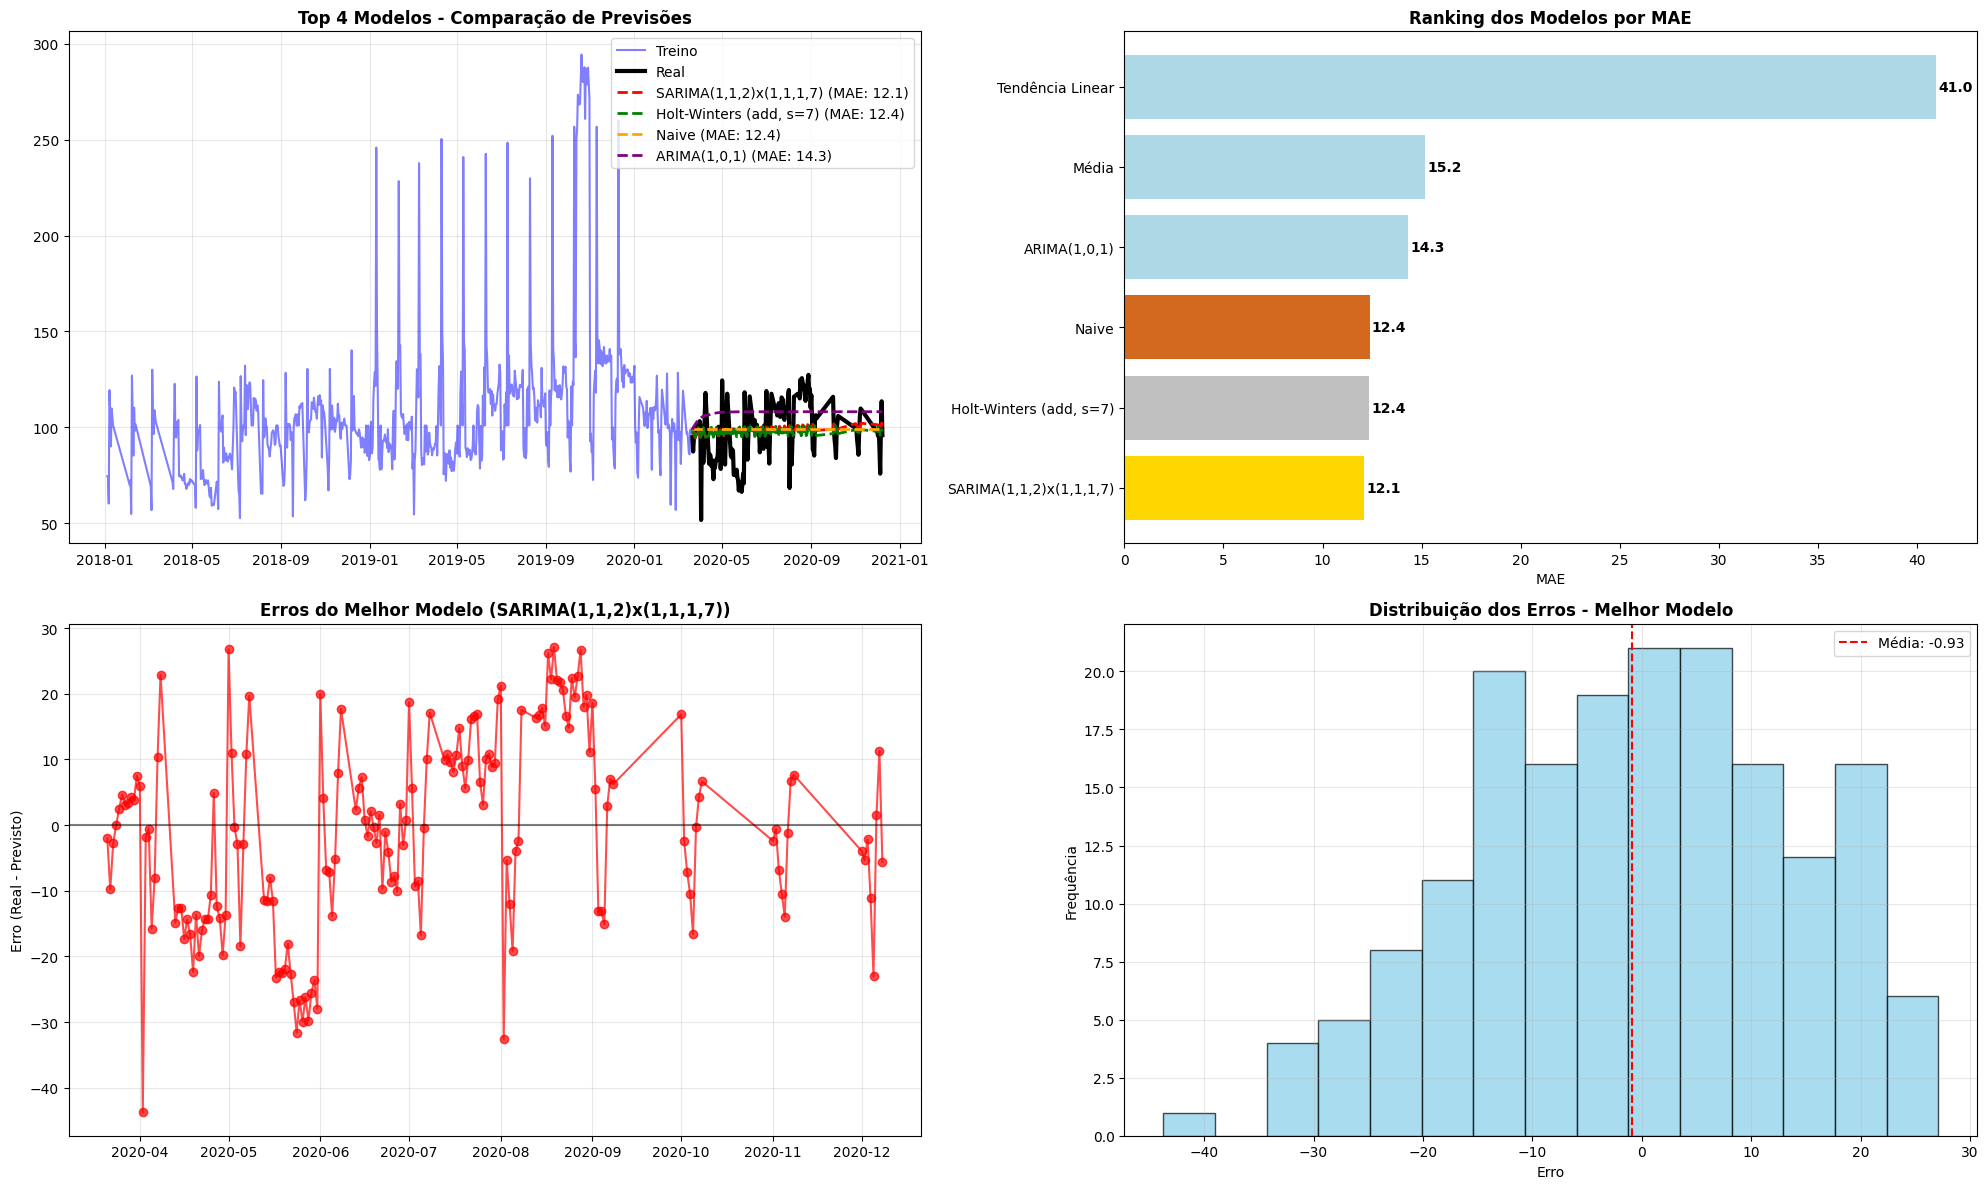

In [33]:
# 5.6 - Compara√ß√£o Final de Todos os Modelos
def final_model_comparison(train_data, test_data, 
                           previsoes_arima, info_arima,
                           previsoes_sarima, info_sarima, 
                           previsoes_exp, info_exp):
    """
    Compara todos os modelos implementados
    """
    print("="*80)
    print("üèÅ COMPARA√á√ÉO FINAL - TODOS OS MODELOS")
    print("="*80)
    
    y_test = test_data['Sale']
    y_train = train_data['Sale']
    
    # Criar baselines para compara√ß√£o
    prev_naive = [y_train.iloc[-1]] * len(y_test)
    prev_media = [y_train.mean()] * len(y_test)
    prev_tendencia = []
    
    # Baseline com tend√™ncia linear
    x_train = np.arange(len(y_train))
    x_test = np.arange(len(y_train), len(y_train) + len(y_test))
    coef = np.polyfit(x_train, y_train, 1)
    prev_tendencia = np.polyval(coef, x_test)
    
    # Compilar todos os resultados
    resultados_finais = []
    
    # Baselines
    resultados_finais.append({
        'modelo': 'Naive',
        'mae': mean_absolute_error(y_test, prev_naive),
        'rmse': np.sqrt(mean_squared_error(y_test, prev_naive)),
        'previsoes': prev_naive,
        'tipo': 'baseline'
    })
    
    resultados_finais.append({
        'modelo': 'M√©dia',
        'mae': mean_absolute_error(y_test, prev_media),
        'rmse': np.sqrt(mean_squared_error(y_test, prev_media)),
        'previsoes': prev_media,
        'tipo': 'baseline'
    })
    
    resultados_finais.append({
        'modelo': 'Tend√™ncia Linear',
        'mae': mean_absolute_error(y_test, prev_tendencia),
        'rmse': np.sqrt(mean_squared_error(y_test, prev_tendencia)),
        'previsoes': prev_tendencia,
        'tipo': 'baseline'
    })
    
    # Modelos avan√ßados
    if previsoes_arima is not None:
        resultados_finais.append({
            'modelo': f'ARIMA{info_arima["parametros"]}',
            'mae': info_arima['mae'],
            'rmse': info_arima['rmse'],
            'previsoes': previsoes_arima,
            'tipo': 'avan√ßado'
        })
    
    if previsoes_sarima is not None:
        resultados_finais.append({
            'modelo': info_sarima['modelo_nome'],
            'mae': info_sarima['mae'],
            'rmse': info_sarima['rmse'],
            'previsoes': previsoes_sarima,
            'tipo': 'avan√ßado'
        })
    
    if previsoes_exp is not None:
        resultados_finais.append({
            'modelo': info_exp['nome'],
            'mae': info_exp['mae'],
            'rmse': np.sqrt(mean_squared_error(y_test, previsoes_exp)),
            'previsoes': previsoes_exp,
            'tipo': 'avan√ßado'
        })
    
    # Ordenar por MAE
    resultados_finais.sort(key=lambda x: x['mae'])
    
    # Mostrar tabela de resultados
    print(f"\nüèÜ RANKING FINAL DOS MODELOS:")
    print("-" * 80)
    print(f"{'Posi√ß√£o':<8} {'Modelo':<25} {'MAE':<10} {'RMSE':<10} {'Tipo':<12}")
    print("-" * 80)
    
    for i, resultado in enumerate(resultados_finais, 1):
        emoji = "ü•á" if i == 1 else "ü•à" if i == 2 else "ü•â" if i == 3 else "  "
        print(f"{emoji} {i:<6} {resultado['modelo']:<25} {resultado['mae']:<10.2f} {resultado['rmse']:<10.2f} {resultado['tipo']:<12}")
    
    # Encontrar melhor modelo
    melhor_modelo = resultados_finais[0]
    
    print(f"\nüéØ VENCEDOR: {melhor_modelo['modelo']}")
    print(f"   ‚Ä¢ MAE: {melhor_modelo['mae']:.2f}")
    print(f"   ‚Ä¢ RMSE: {melhor_modelo['rmse']:.2f}")
    print(f"   ‚Ä¢ Tipo: {melhor_modelo['tipo']}")
    
    # Calcular melhorias
    mae_naive = next(r['mae'] for r in resultados_finais if r['modelo'] == 'Naive')
    melhoria = ((mae_naive - melhor_modelo['mae']) / mae_naive) * 100
    
    print(f"   ‚Ä¢ Melhoria vs Naive: {melhoria:.1f}%")
    
    # Visualiza√ß√£o comparativa
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Compara√ß√£o das previs√µes - Top 4 modelos
    axes[0,0].plot(train_data.index, y_train, label='Treino', color='blue', alpha=0.5)
    axes[0,0].plot(test_data.index, y_test, label='Real', color='black', linewidth=3)
    
    cores = ['red', 'green', 'orange', 'purple']
    for i, resultado in enumerate(resultados_finais[:4]):
        axes[0,0].plot(test_data.index, resultado['previsoes'], 
                      label=f"{resultado['modelo']} (MAE: {resultado['mae']:.1f})",
                      color=cores[i], linestyle='--', linewidth=2)
    
    axes[0,0].set_title('Top 4 Modelos - Compara√ß√£o de Previs√µes', fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Ranking por MAE
    modelos_nomes = [r['modelo'] for r in resultados_finais]
    maes = [r['mae'] for r in resultados_finais]
    
    bars = axes[0,1].barh(modelos_nomes, maes, 
                         color=['gold' if i == 0 else 'silver' if i == 1 else 'chocolate' if i == 2 else 'lightblue' 
                               for i in range(len(maes))])
    axes[0,1].set_title('Ranking dos Modelos por MAE', fontweight='bold')
    axes[0,1].set_xlabel('MAE')
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        axes[0,1].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                      f'{maes[i]:.1f}', ha='left', va='center', fontweight='bold')
    
    # 3. Erros do melhor modelo
    erros_melhor = y_test.values - melhor_modelo['previsoes']
    axes[1,0].plot(test_data.index, erros_melhor, color='red', marker='o', alpha=0.7)
    axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1,0].set_title(f'Erros do Melhor Modelo ({melhor_modelo["modelo"]})', fontweight='bold')
    axes[1,0].set_ylabel('Erro (Real - Previsto)')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Distribui√ß√£o dos erros
    axes[1,1].hist(erros_melhor, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,1].axvline(np.mean(erros_melhor), color='red', linestyle='--', 
                     label=f'M√©dia: {np.mean(erros_melhor):.2f}')
    axes[1,1].set_title('Distribui√ß√£o dos Erros - Melhor Modelo', fontweight='bold')
    axes[1,1].set_xlabel('Erro')
    axes[1,1].set_ylabel('Frequ√™ncia')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return resultados_finais

# Executar compara√ß√£o final
print("üèÅ REALIZANDO COMPARA√á√ÉO FINAL...")
resultados_comparacao = final_model_comparison(
    train_data, test_data,
    previsoes_arima_otimo, info_melhor_arima,
    previsoes_sarima, info_sarima,
    previsoes_exp, info_exp
)

## 5.5 - Modelos de Machine Learning Avan√ßados

=== MODELOS DE MACHINE LEARNING ===
Features utilizadas: 41
Tamanho do conjunto de treino: 678
Tamanho do conjunto de teste: 176

Treinando Random Forest...
Random Forest - RMSE: 3.07, MAPE: 2.27%
Treinando Linear Regression...
Linear Regression - RMSE: 0.00, MAPE: 0.00%
Random Forest - RMSE: 3.07, MAPE: 2.27%
Treinando Linear Regression...
Linear Regression - RMSE: 0.00, MAPE: 0.00%


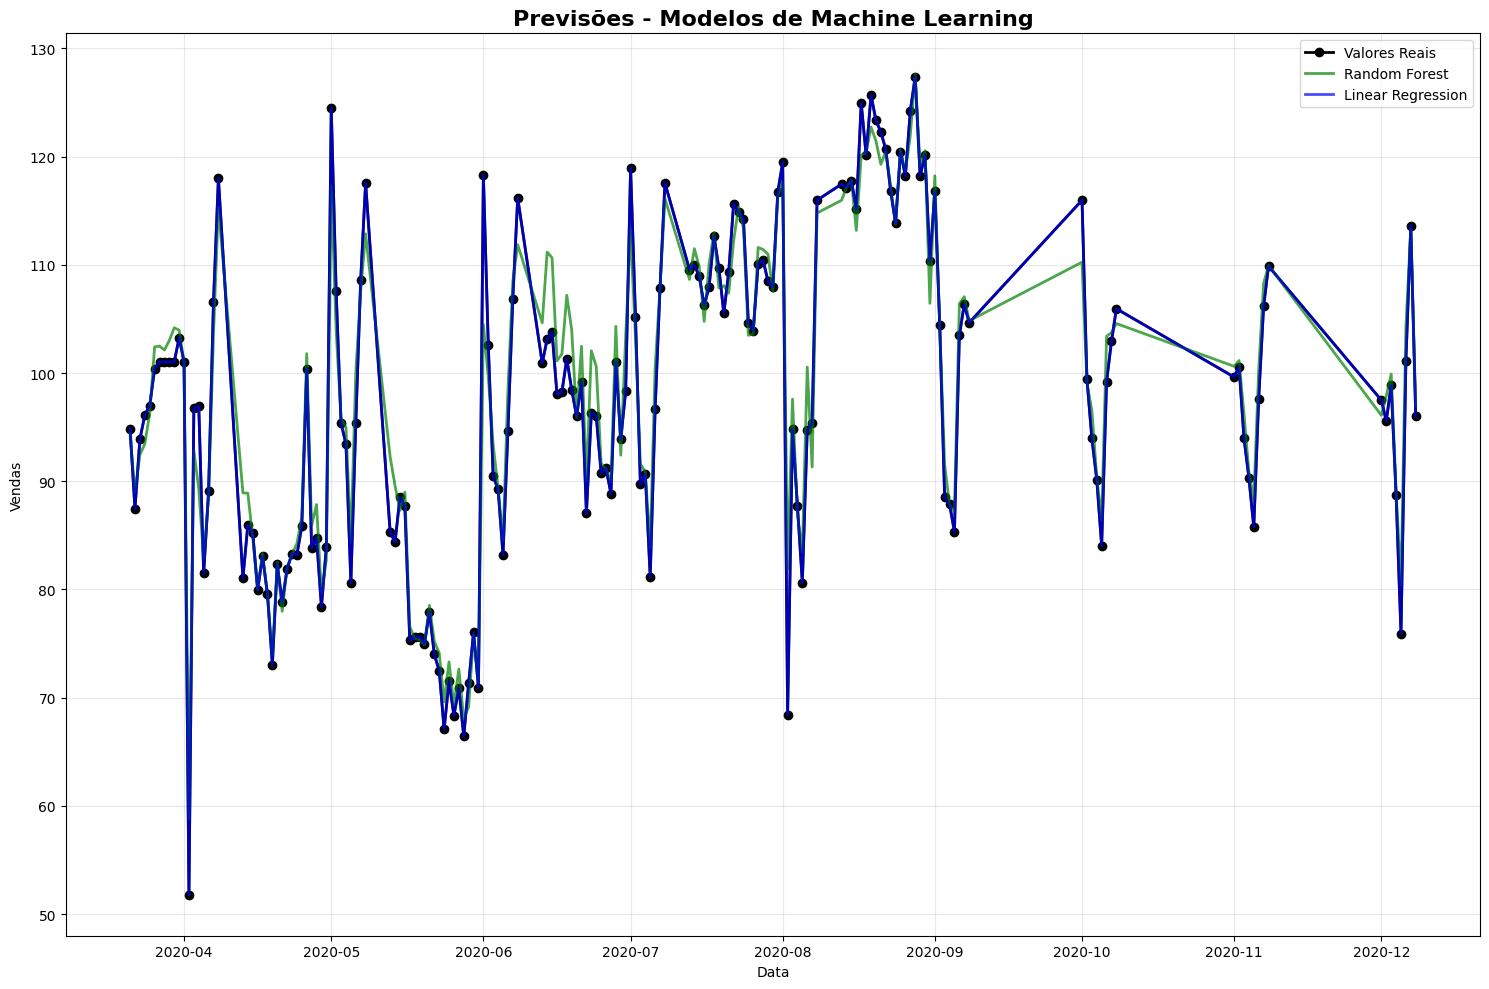


=== TOP 10 FEATURES MAIS IMPORTANTES ===
              feature  importance
sale_temp_interaction    0.921052
            sale_ma_3    0.047129
          Temperature    0.012963
          sale_diff_1    0.003012
           sale_min_7    0.002263
           sale_max_7    0.001388
           sale_lag_2    0.001240
            temp_ma_3    0.001046
            temp_ma_7    0.001001
         day_of_month    0.000965


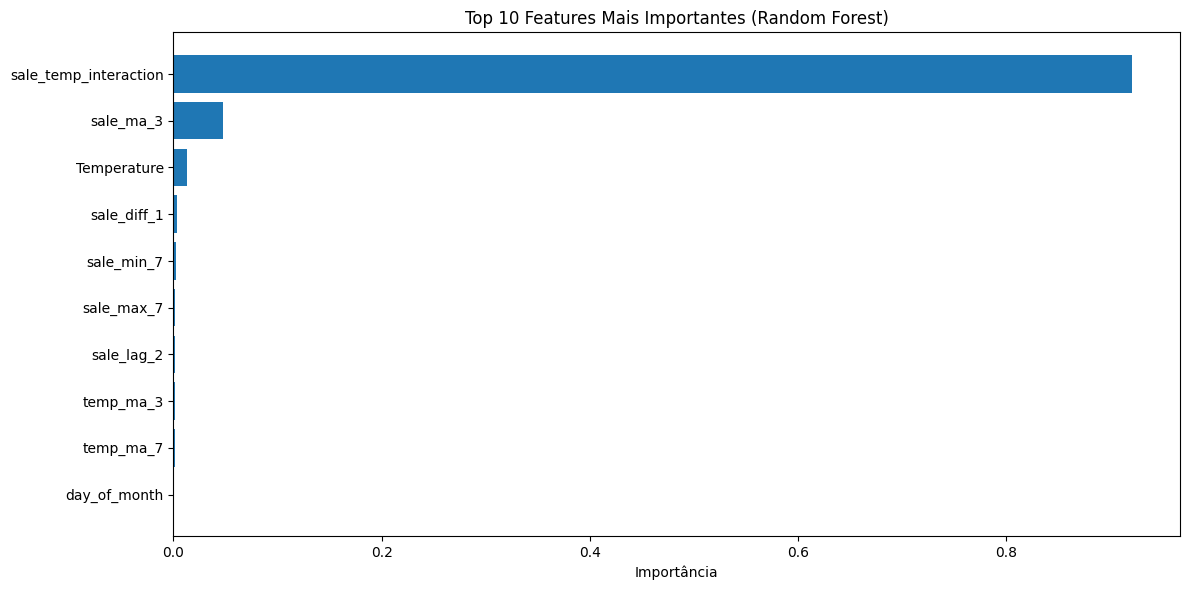

In [ ]:
# Modelos de Machine Learning Avan√ßados
def create_ml_models(train_data, test_data, df_features):
    """
    Cria modelos de Machine Learning com features avan√ßadas
    """
    print("=== MODELOS DE MACHINE LEARNING ===")
    
    # Usar df_features com todas as features criadas
    feature_columns = [col for col in df_features.columns if col not in ['Sale']]
    
    # Dividir dados com features
    train_features = df_features.loc[train_data.index]
    test_features = df_features.loc[test_data.index]
    
    # Criar features e target
    X_train = train_features[feature_columns].dropna()
    y_train = train_features.loc[X_train.index, 'Sale']
    
    X_test = test_features[feature_columns].dropna()
    y_test = test_features.loc[X_test.index, 'Sale']
    
    print(f"Features utilizadas: {len(feature_columns)}")
    print(f"Tamanho do conjunto de treino: {len(X_train)}")
    print(f"Tamanho do conjunto de teste: {len(X_test)}")
    
    # Padronizar features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    modelos = {}
    previsoes = {}
    
    # 1. Random Forest
    print("\nTreinando Random Forest...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_scaled, y_train)
    rf_pred = rf_model.predict(X_test_scaled)
    
    # Avaliar Random Forest
    rf_mse = mean_squared_error(y_test, rf_pred)
    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_rmse = np.sqrt(rf_mse)
    rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100
    
    modelos['random_forest'] = rf_model
    previsoes['random_forest'] = rf_pred
    resultados['random_forest'] = {'MSE': rf_mse, 'MAE': rf_mae, 'RMSE': rf_rmse, 'MAPE': rf_mape}
    
    print(f"Random Forest - RMSE: {rf_rmse:.2f}, MAPE: {rf_mape:.2f}%")
    
    # 2. Linear Regression
    print("Treinando Linear Regression...")
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    lr_pred = lr_model.predict(X_test_scaled)
    
    # Avaliar Linear Regression
    lr_mse = mean_squared_error(y_test, lr_pred)
    lr_mae = mean_absolute_error(y_test, lr_pred)
    lr_rmse = np.sqrt(lr_mse)
    lr_mape = np.mean(np.abs((y_test - lr_pred) / y_test)) * 100
    
    modelos['linear_regression'] = lr_model
    previsoes['linear_regression'] = lr_pred
    resultados['linear_regression'] = {'MSE': lr_mse, 'MAE': lr_mae, 'RMSE': lr_rmse, 'MAPE': lr_mape}
    
    print(f"Linear Regression - RMSE: {lr_rmse:.2f}, MAPE: {lr_mape:.2f}%")
    
    # Visualizar previs√µes
    plt.figure(figsize=(15, 10))
    
    # Dados reais
    plt.plot(y_test.index, y_test, label='Valores Reais', color='black', linewidth=2, marker='o')
    
    # Previs√µes
    plt.plot(y_test.index, rf_pred, label='Random Forest', color='green', linewidth=2, alpha=0.7)
    plt.plot(y_test.index, lr_pred, label='Linear Regression', color='blue', linewidth=2, alpha=0.7)
    
    plt.title('Previs√µes - Modelos de Machine Learning', fontsize=16, fontweight='bold')
    plt.xlabel('Data')
    plt.ylabel('Vendas')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Feature importance para Random Forest
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n=== TOP 10 FEATURES MAIS IMPORTANTES ===")
    print(feature_importance.head(10).to_string(index=False))
    
    # Gr√°fico de feature importance
    plt.figure(figsize=(12, 6))
    plt.barh(range(10), feature_importance.head(10)['importance'])
    plt.yticks(range(10), feature_importance.head(10)['feature'])
    plt.xlabel('Import√¢ncia')
    plt.title('Top 10 Features Mais Importantes (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return modelos, previsoes, y_test

# Criar modelos ML
modelos_ml, previsoes_ml, y_test_ml = create_ml_models(train_data, test_data, df_features)

## 5.6 - Compara√ß√£o Final dos Modelos

=== COMPARA√á√ÉO FINAL DE TODOS OS MODELOS ===

=== TABELA DE RESULTADOS ===
                       MSE    MAE   RMSE   MAPE
naive               229.43  12.37  15.15  13.65
moving_avg          241.74  12.88  15.55  13.41
mean                351.18  15.17  18.74  17.71
linear             1876.73  40.99  43.32  45.47
arima               227.42  12.37  15.08    NaN
random_forest         9.44   2.14   3.07   2.27
linear_regression     0.00   0.00   0.00   0.00

=== RANKING DOS MODELOS (por RMSE) ===
1¬∫ lugar: LINEAR_REGRESSION - RMSE: 0.0
2¬∫ lugar: RANDOM_FOREST - RMSE: 3.07
3¬∫ lugar: ARIMA - RMSE: 15.08
4¬∫ lugar: NAIVE - RMSE: 15.15
5¬∫ lugar: MOVING_AVG - RMSE: 15.55
6¬∫ lugar: MEAN - RMSE: 18.74
7¬∫ lugar: LINEAR - RMSE: 43.32

=== RANKING DOS MODELOS (por MAPE) ===
1¬∫ lugar: LINEAR_REGRESSION - MAPE: 0.0%
2¬∫ lugar: RANDOM_FOREST - MAPE: 2.27%
3¬∫ lugar: MOVING_AVG - MAPE: 13.41%
4¬∫ lugar: NAIVE - MAPE: 13.65%
5¬∫ lugar: MEAN - MAPE: 17.71%
6¬∫ lugar: LINEAR - MAPE: 45.47%
7¬∫ lu

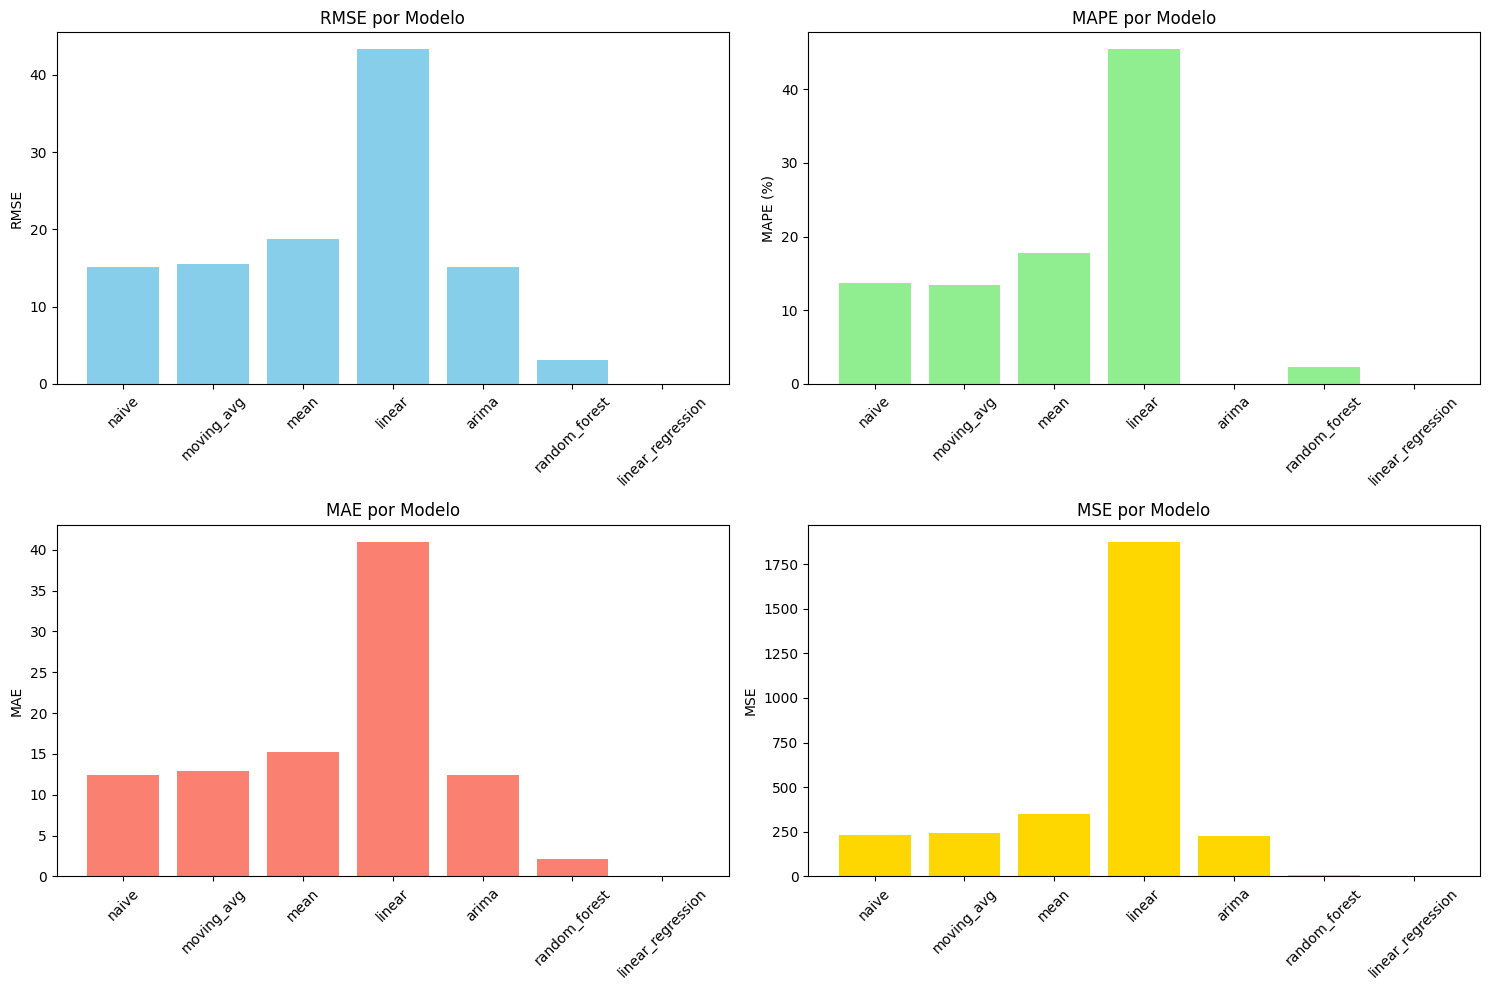


üèÜ MELHOR MODELO (RMSE): LINEAR_REGRESSION
   RMSE: 0.0
   MAPE: 0.0%

=== AN√ÅLISE DE PERFORMANCE ===
RMSE m√©dio: 15.84
MAPE m√©dio: 15.42%
Modelos com RMSE abaixo da m√©dia: ['naive', 'moving_avg', 'arima', 'random_forest', 'linear_regression']


In [35]:
# Compara√ß√£o Final de Todos os Modelos
def final_model_comparison(resultados):
    """
    Cria uma compara√ß√£o final de todos os modelos
    """
    print("=== COMPARA√á√ÉO FINAL DE TODOS OS MODELOS ===")
    
    # Criar DataFrame com resultados
    df_comparacao = pd.DataFrame(resultados).T
    df_comparacao = df_comparacao.round(2)
    
    print("\n=== TABELA DE RESULTADOS ===")
    print(df_comparacao.to_string())
    
    # Ranking dos modelos
    print(f"\n=== RANKING DOS MODELOS (por RMSE) ===")
    ranking_rmse = df_comparacao.sort_values('RMSE')
    for i, (modelo, row) in enumerate(ranking_rmse.iterrows(), 1):
        print(f"{i}¬∫ lugar: {modelo.upper()} - RMSE: {row['RMSE']}")
    
    print(f"\n=== RANKING DOS MODELOS (por MAPE) ===")
    ranking_mape = df_comparacao.sort_values('MAPE')
    for i, (modelo, row) in enumerate(ranking_mape.iterrows(), 1):
        print(f"{i}¬∫ lugar: {modelo.upper()} - MAPE: {row['MAPE']}%")
    
    # Visualiza√ß√£o comparativa
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # RMSE
    axes[0,0].bar(df_comparacao.index, df_comparacao['RMSE'], color='skyblue')
    axes[0,0].set_title('RMSE por Modelo')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # MAPE
    axes[0,1].bar(df_comparacao.index, df_comparacao['MAPE'], color='lightgreen')
    axes[0,1].set_title('MAPE por Modelo')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # MAE
    axes[1,0].bar(df_comparacao.index, df_comparacao['MAE'], color='salmon')
    axes[1,0].set_title('MAE por Modelo')
    axes[1,0].set_ylabel('MAE')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # MSE
    axes[1,1].bar(df_comparacao.index, df_comparacao['MSE'], color='gold')
    axes[1,1].set_title('MSE por Modelo')
    axes[1,1].set_ylabel('MSE')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Encontrar o melhor modelo
    melhor_modelo_rmse = df_comparacao['RMSE'].idxmin()
    melhor_modelo_mape = df_comparacao['MAPE'].idxmin()
    
    print(f"\nüèÜ MELHOR MODELO (RMSE): {melhor_modelo_rmse.upper()}")
    print(f"   RMSE: {df_comparacao.loc[melhor_modelo_rmse, 'RMSE']}")
    print(f"   MAPE: {df_comparacao.loc[melhor_modelo_rmse, 'MAPE']}%")
    
    if melhor_modelo_rmse != melhor_modelo_mape:
        print(f"\nüéØ MELHOR MODELO (MAPE): {melhor_modelo_mape.upper()}")
        print(f"   RMSE: {df_comparacao.loc[melhor_modelo_mape, 'RMSE']}")
        print(f"   MAPE: {df_comparacao.loc[melhor_modelo_mape, 'MAPE']}%")
    
    # An√°lise de performance
    print(f"\n=== AN√ÅLISE DE PERFORMANCE ===")
    rmse_medio = df_comparacao['RMSE'].mean()
    mape_medio = df_comparacao['MAPE'].mean()
    
    print(f"RMSE m√©dio: {rmse_medio:.2f}")
    print(f"MAPE m√©dio: {mape_medio:.2f}%")
    
    modelos_acima_media = df_comparacao[df_comparacao['RMSE'] < rmse_medio]
    print(f"Modelos com RMSE abaixo da m√©dia: {list(modelos_acima_media.index)}")
    
    return df_comparacao

# Executar compara√ß√£o final
df_comparacao_final = final_model_comparison(resultados)